In [44]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [45]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [46]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [47]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [48]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [49]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [50]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [51]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [53]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Feature selection</h3>

In [54]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.031060
JobSatisfaction                                    0.011005
JobRole_Sales_Representative                       0.010333
JobRole_Laboratory_Technician                      0.007755
JobRole_Manufacturing_Director                     0.007492
EnvironmentSatisfaction                            0.007401
StockOptionLevel                                   0.006989
JobRole_Research_Scientist                         0.005875
WorkLifeBalance                                    0.005068
JobInvolvement                                     0.004890
TrainingTimesLastYear                              0.004502
RelationshipSatisfaction                           0.004434
OverallSatisfaction                                0.003828
Age                                                0.002637
NumCompaniesWorked                                 0.002505
JobRole_Healthcare_Representative                  0.002472
YearsInCurrentRole                      

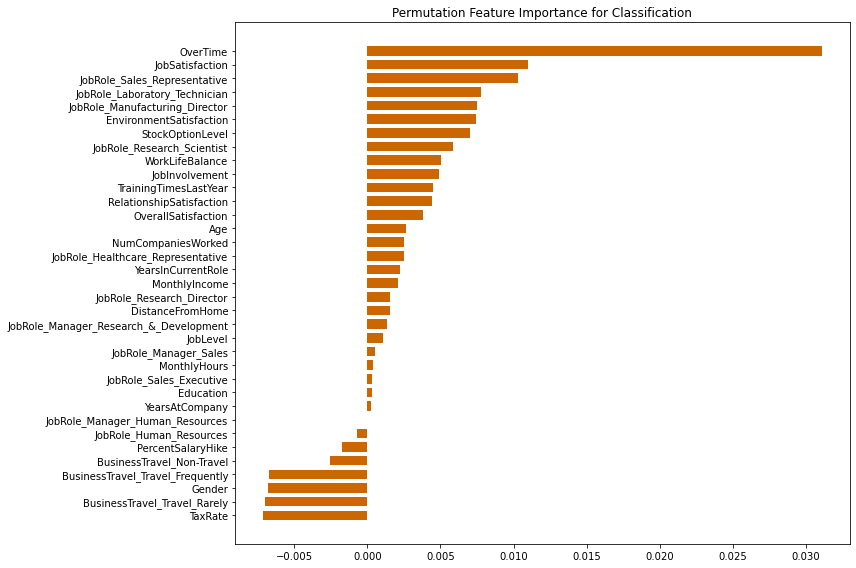

In [55]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [56]:
df = df.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     883 non-null    int64
 1   Attrition                               883 non-null    int64
 2   DistanceFromHome                        883 non-null    int64
 3   EnvironmentSatisfaction                 883 non-null    int64
 4   JobInvolvement                          883 non-null    int64
 5   JobLevel                                883 non-null    int64
 6   JobRole_Laboratory_Technician           883 non-null    int64
 7   JobRole_Manager_Research_&_Development  883 non-null    int64
 8   JobRole_Manufacturing_Director          883 non-null    int64
 9   JobRole_Research_Director               883 non-null    int64
 10  JobRole_Research_Scientist              883 non-null    int64
 11  JobRole_Sales_Repre

<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [58]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [59]:
remaining_columns = []

for column in columns_to_discretize:
    if column in df:
        remaining_columns.append(column)
        
remaining_columns

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [60]:
columns_to_discretize = remaining_columns
columns_to_discretize

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [61]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','NumCompaniesWorked'])], 
                       remainder = "drop")

In [62]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [63]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,NumCompaniesWorked
0,3.0,1.0,3.0
1,1.0,0.0,0.0
2,0.0,2.0,0.0
3,1.0,0.0,0.0
4,1.0,1.0,0.0


In [64]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [65]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [66]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3.0,0,1.0,2,3,3,0,0,0,1,0,0,3,3.0,0,3,0,2,2,2
1,1.0,0,0.0,2,3,5,0,1,0,0,0,0,3,0.0,1,3,1,3,3,2
2,0.0,0,2.0,3,3,2,0,0,0,0,0,0,4,0.0,1,3,1,4,3,3
3,1.0,0,0.0,2,3,1,0,0,0,0,1,0,2,0.0,0,2,0,1,3,2
4,1.0,0,1.0,3,3,1,1,0,0,0,0,0,4,0.0,0,3,0,2,3,3


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    float64
 1   Attrition                               883 non-null    int64  
 2   DistanceFromHome                        883 non-null    float64
 3   EnvironmentSatisfaction                 883 non-null    int64  
 4   JobInvolvement                          883 non-null    int64  
 5   JobLevel                                883 non-null    int64  
 6   JobRole_Laboratory_Technician           883 non-null    int64  
 7   JobRole_Manager_Research_&_Development  883 non-null    int64  
 8   JobRole_Manufacturing_Director          883 non-null    int64  
 9   JobRole_Research_Director               883 non-null    int64  
 10  JobRole_Research_Scientist              883 non-null    int64 

<h3>Divide into features and target</h3>

In [68]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [69]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6438680784711898
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


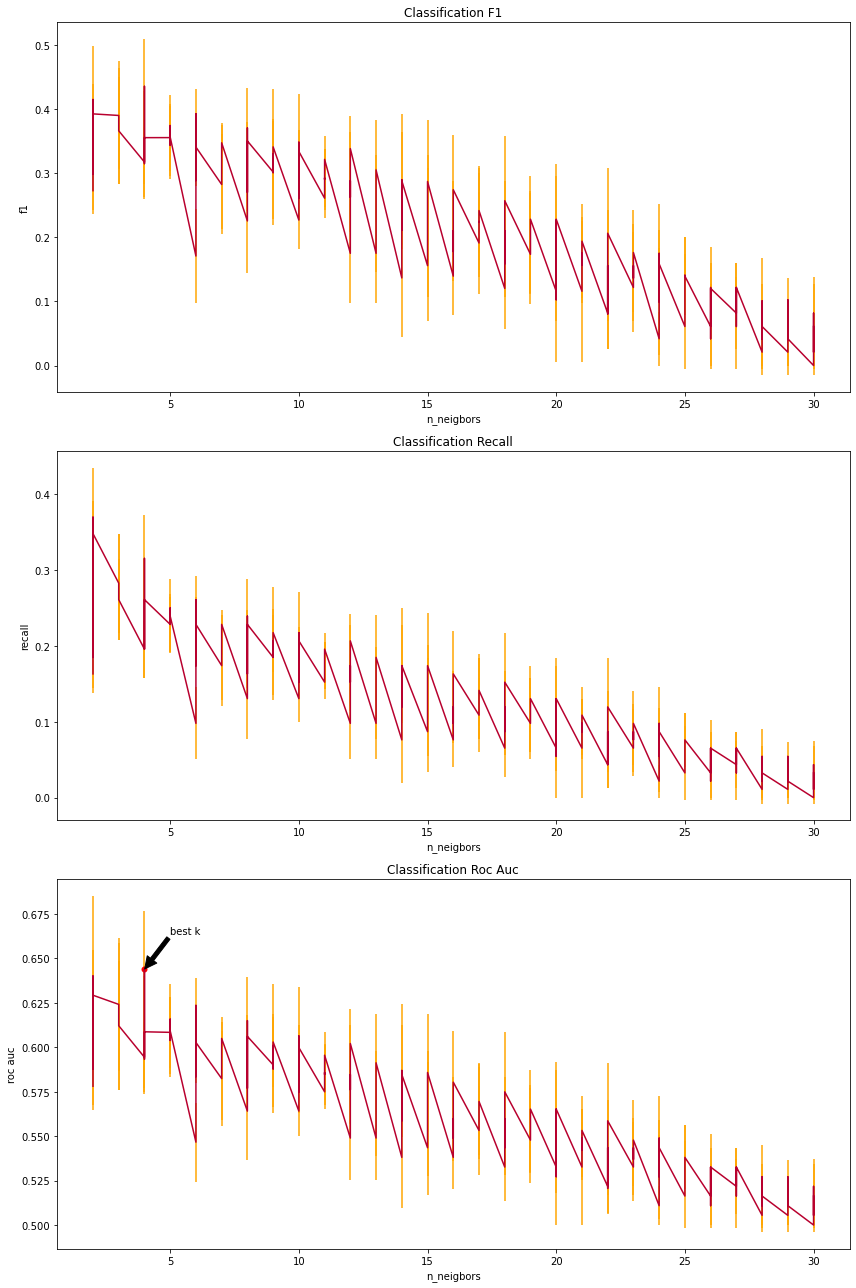



Permutation importances of the training set

OverTime                                           0.005203
JobRole_Laboratory_Technician                      0.002843
RelationshipSatisfaction                           0.001062
JobRole_Sales_Representative                       0.000958
EnvironmentSatisfaction                            0.000691
JobSatisfaction                                    0.000542
DistanceFromHome                                   0.000448
NumCompaniesWorked                                 0.000428
StockOptionLevel                                   0.000425
JobRole_Research_Scientist                         0.000274
JobInvolvement                                     0.000201
Age                                                0.000159
JobRole_Manufacturing_Director                     0.000127
WorkLifeBalance                                    0.000109
TrainingTimesLastYear                              0.000020
JobRole_Research_Director                          0.

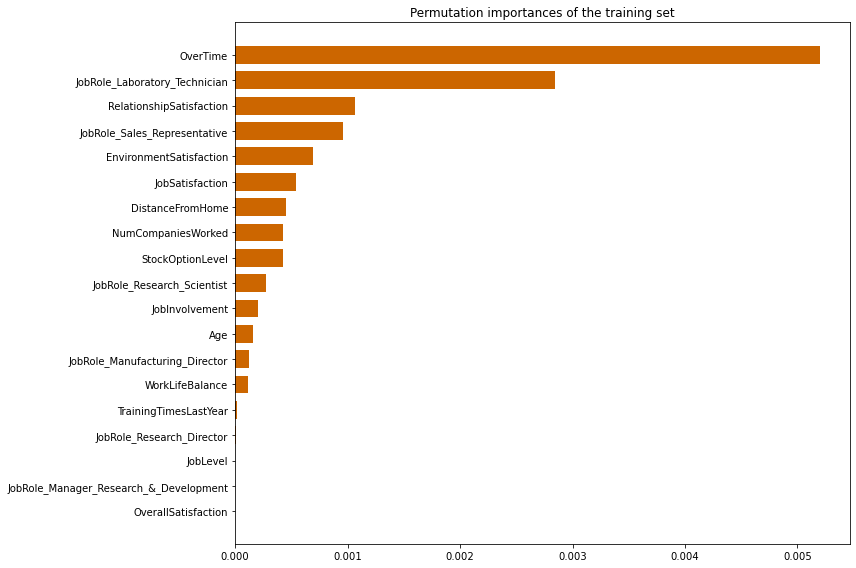



Predictions

Permutation importances of the test set

OverTime                                           0.067666
Age                                                0.040091
JobSatisfaction                                    0.028182
JobRole_Sales_Representative                       0.025645
EnvironmentSatisfaction                            0.025049
JobLevel                                           0.018562
StockOptionLevel                                   0.017915
JobRole_Research_Scientist                         0.011750
JobInvolvement                                     0.009811
RelationshipSatisfaction                           0.008896
JobRole_Manufacturing_Director                     0.008421
JobRole_Laboratory_Technician                      0.007895
OverallSatisfaction                                0.005125
JobRole_Research_Director                          0.002020
JobRole_Manager_Research_&_Development             0.001914
WorkLifeBalance                             

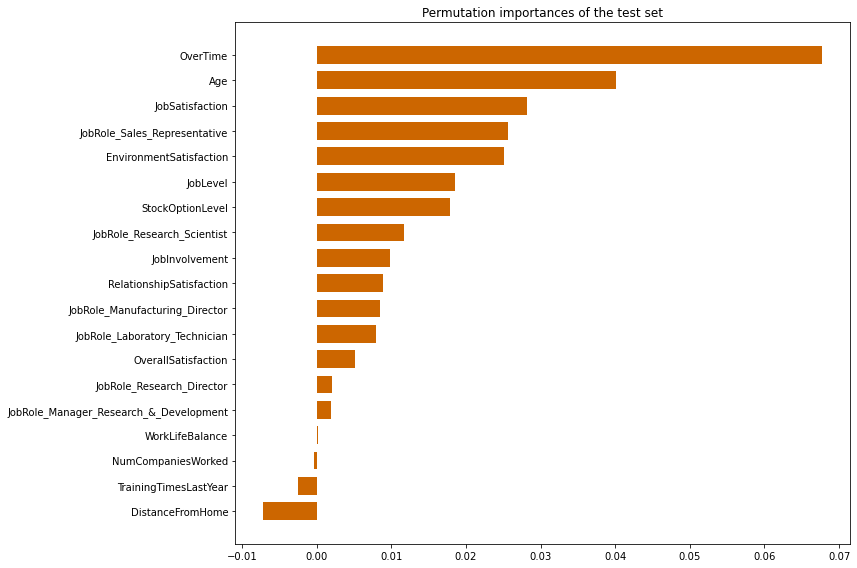



Confusion matrix


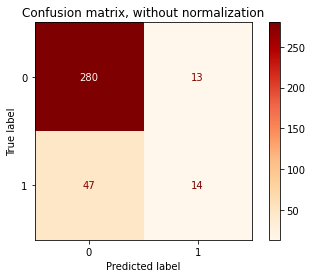

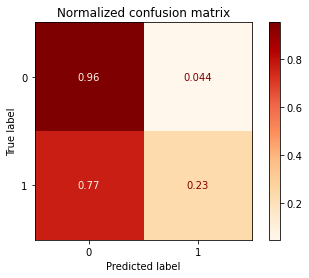


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       293
           1       0.52      0.23      0.32        61

    accuracy                           0.83       354
   macro avg       0.69      0.59      0.61       354
weighted avg       0.80      0.83      0.80       354


Metrics

Accuracy 0.8305084745762712
F1-score [0.90322581 0.31818182]
Precision [0.85626911 0.51851852]
Recall [0.9556314 0.2295082]
Roc_auc 0.5925697980193588


Roc curve



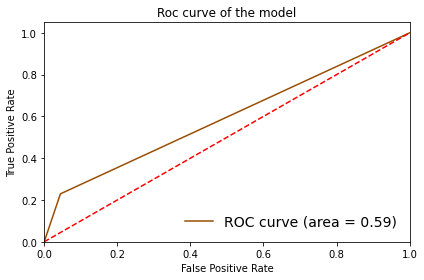


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6257091617804585
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


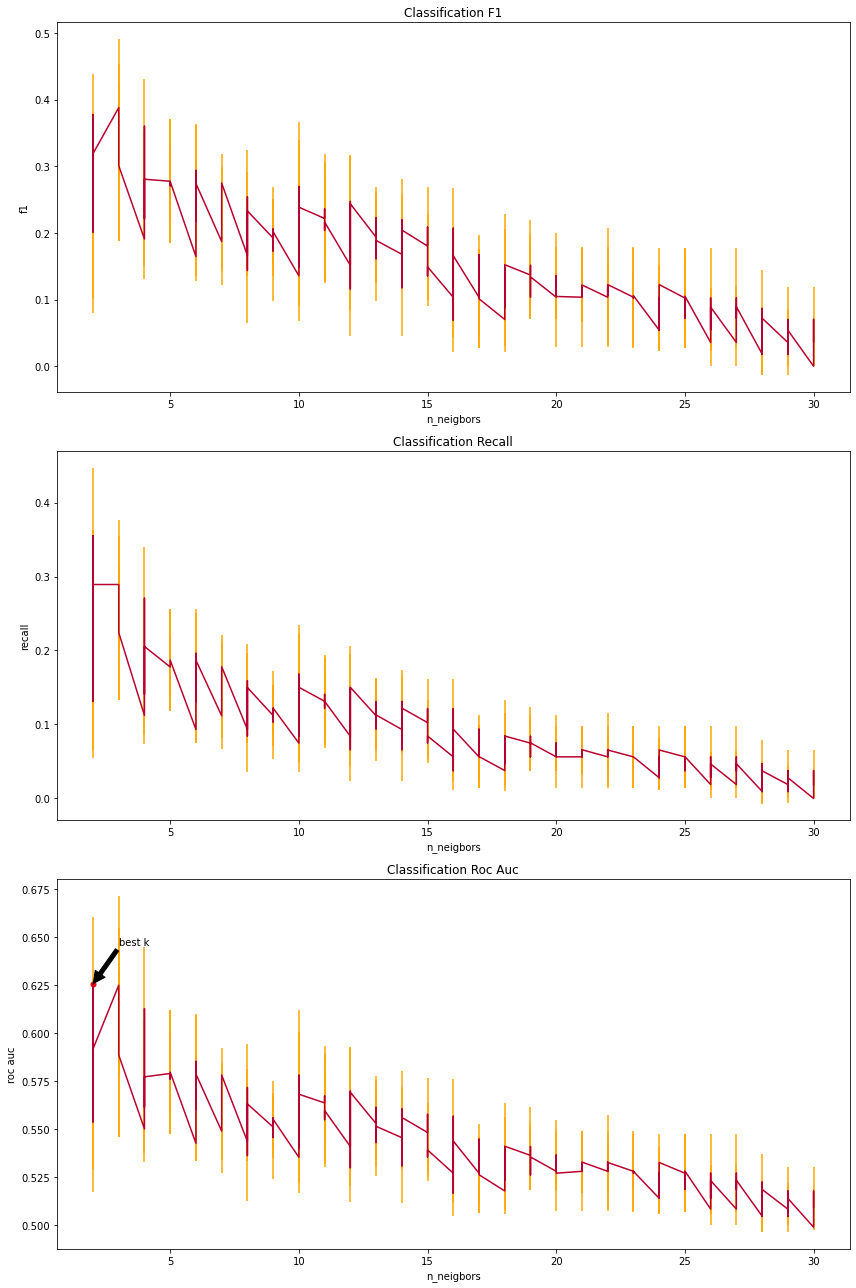



Permutation importances of the training set

OverTime                                           0.004427
DistanceFromHome                                   0.001008
RelationshipSatisfaction                           0.000064
JobSatisfaction                                    0.000047
JobRole_Laboratory_Technician                      0.000031
StockOptionLevel                                   0.000030
JobRole_Research_Scientist                         0.000026
Age                                                0.000024
EnvironmentSatisfaction                            0.000009
JobInvolvement                                     0.000007
NumCompaniesWorked                                 0.000006
JobRole_Sales_Representative                       0.000002
WorkLifeBalance                                    0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.

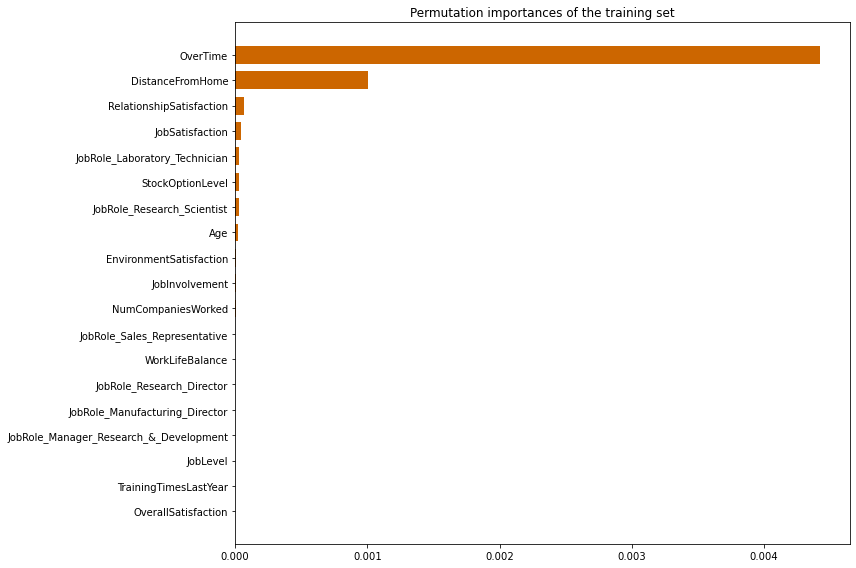



Predictions

Permutation importances of the test set

OverTime                                           0.109266
JobSatisfaction                                    0.071858
JobInvolvement                                     0.059728
WorkLifeBalance                                    0.057093
StockOptionLevel                                   0.042843
Age                                                0.041786
JobRole_Sales_Representative                       0.037433
RelationshipSatisfaction                           0.031055
EnvironmentSatisfaction                            0.029120
OverallSatisfaction                                0.028062
DistanceFromHome                                   0.022062
NumCompaniesWorked                                 0.021565
JobLevel                                           0.010522
JobRole_Laboratory_Technician                      0.010418
JobRole_Research_Scientist                         0.007465
JobRole_Research_Director                   

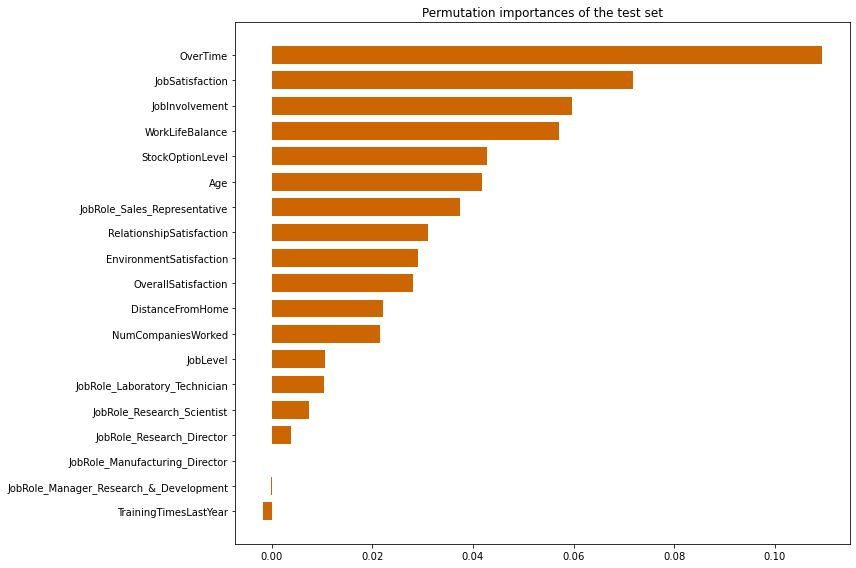



Confusion matrix


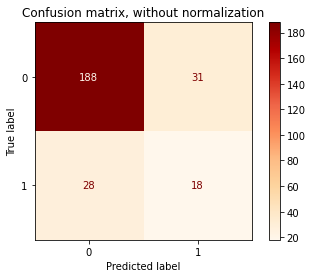

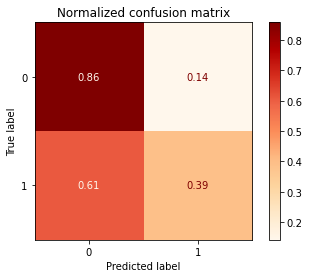


Classification report
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       219
           1       0.37      0.39      0.38        46

    accuracy                           0.78       265
   macro avg       0.62      0.62      0.62       265
weighted avg       0.78      0.78      0.78       265


Metrics

Accuracy 0.7773584905660378
F1-score [0.86436782 0.37894737]
Precision [0.87037037 0.36734694]
Recall [0.85844749 0.39130435]
Roc_auc 0.6248759182052808


Roc curve



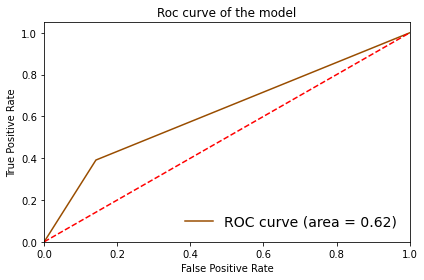


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6931341140079541
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


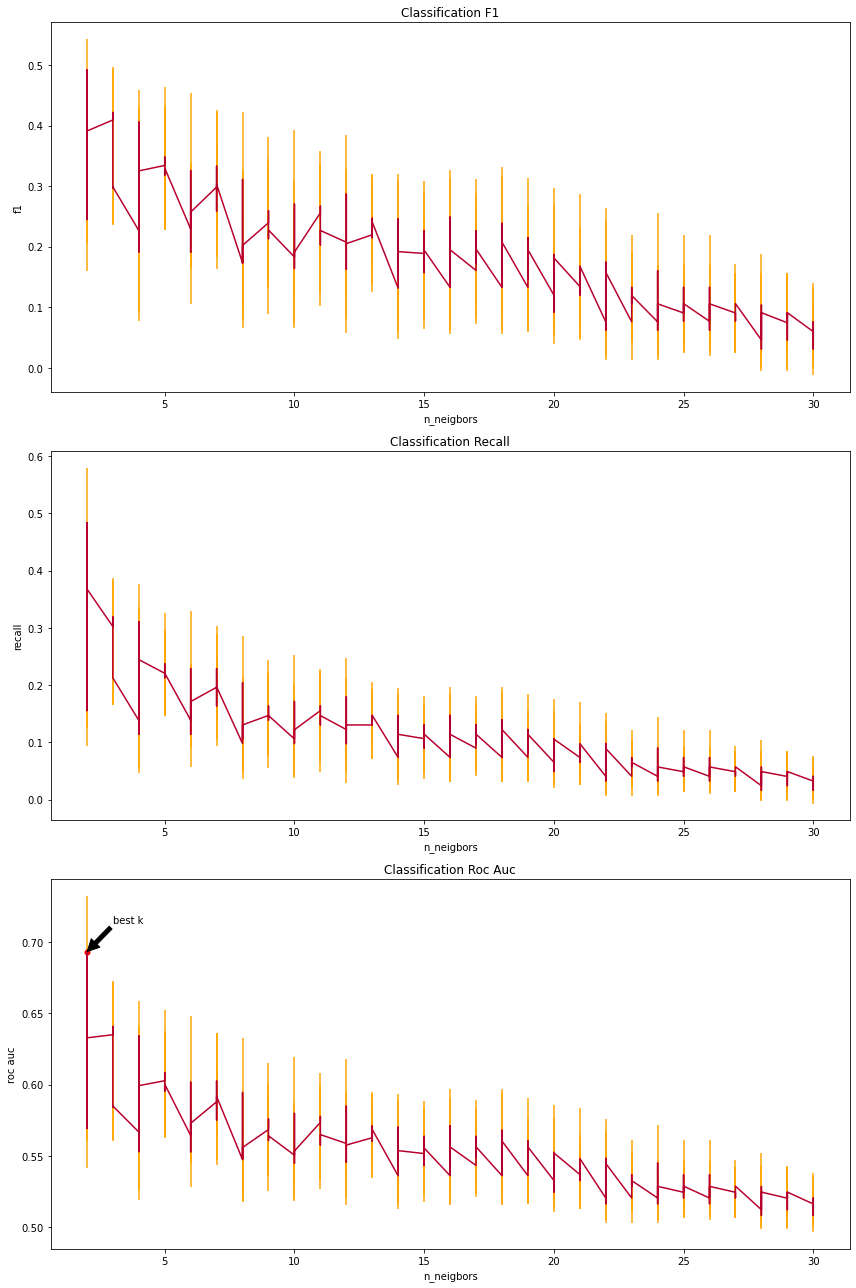



Permutation importances of the training set

OverTime                                           0.004241
JobRole_Sales_Representative                       0.003752
DistanceFromHome                                   0.001313
EnvironmentSatisfaction                            0.000149
JobSatisfaction                                    0.000114
JobRole_Laboratory_Technician                      0.000069
RelationshipSatisfaction                           0.000065
StockOptionLevel                                   0.000040
Age                                                0.000022
JobRole_Research_Scientist                         0.000020
JobInvolvement                                     0.000006
TrainingTimesLastYear                              0.000006
NumCompaniesWorked                                 0.000004
OverallSatisfaction                                0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

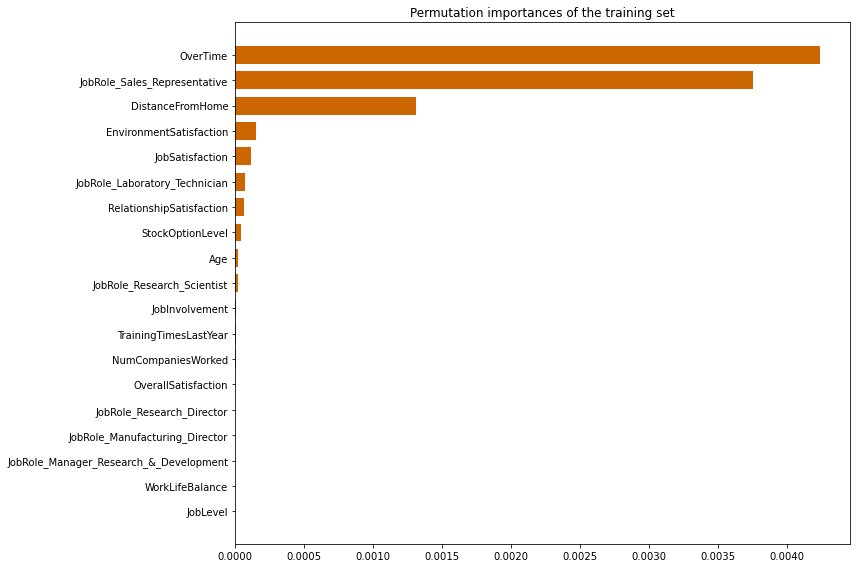



Predictions

Permutation importances of the test set

OverTime                                           0.092300
StockOptionLevel                                   0.058429
JobSatisfaction                                    0.057346
WorkLifeBalance                                    0.053911
JobRole_Laboratory_Technician                      0.046719
Age                                                0.039428
JobRole_Research_Scientist                         0.028999
JobInvolvement                                     0.022194
EnvironmentSatisfaction                            0.021973
JobRole_Sales_Representative                       0.018802
JobLevel                                           0.018372
NumCompaniesWorked                                 0.018294
OverallSatisfaction                                0.016019
RelationshipSatisfaction                           0.015157
DistanceFromHome                                   0.013224
TrainingTimesLastYear                       

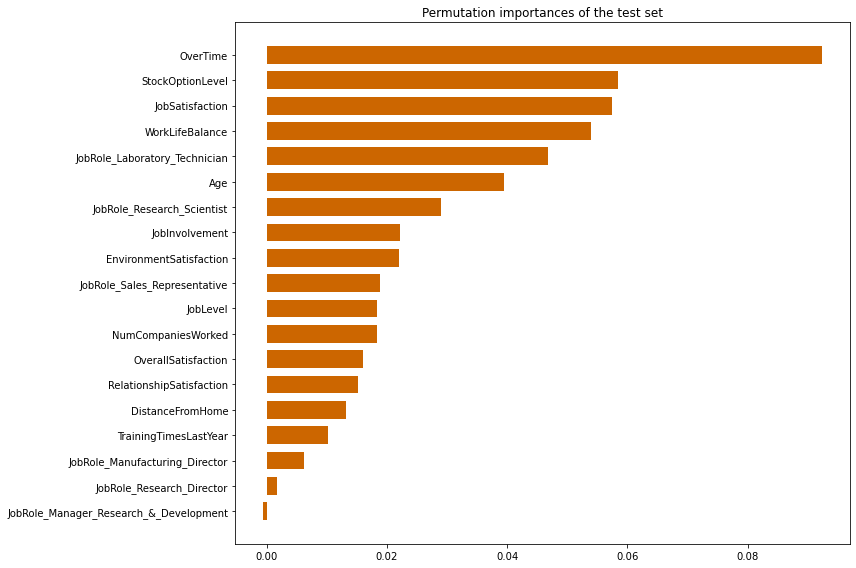



Confusion matrix


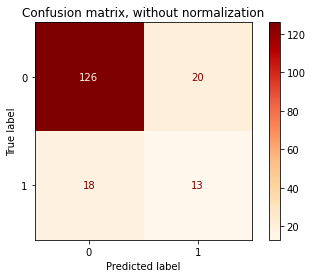

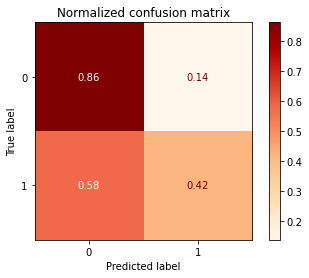


Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       146
           1       0.39      0.42      0.41        31

    accuracy                           0.79       177
   macro avg       0.63      0.64      0.64       177
weighted avg       0.79      0.79      0.79       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.86896552 0.40625   ]
Precision [0.875      0.39393939]
Recall [0.8630137  0.41935484]
Roc_auc 0.6411842686699072


Roc curve



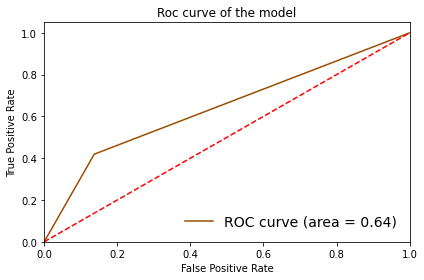


-------------------------------------------------------------------------------------------------------------



In [70]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6641530985966566
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


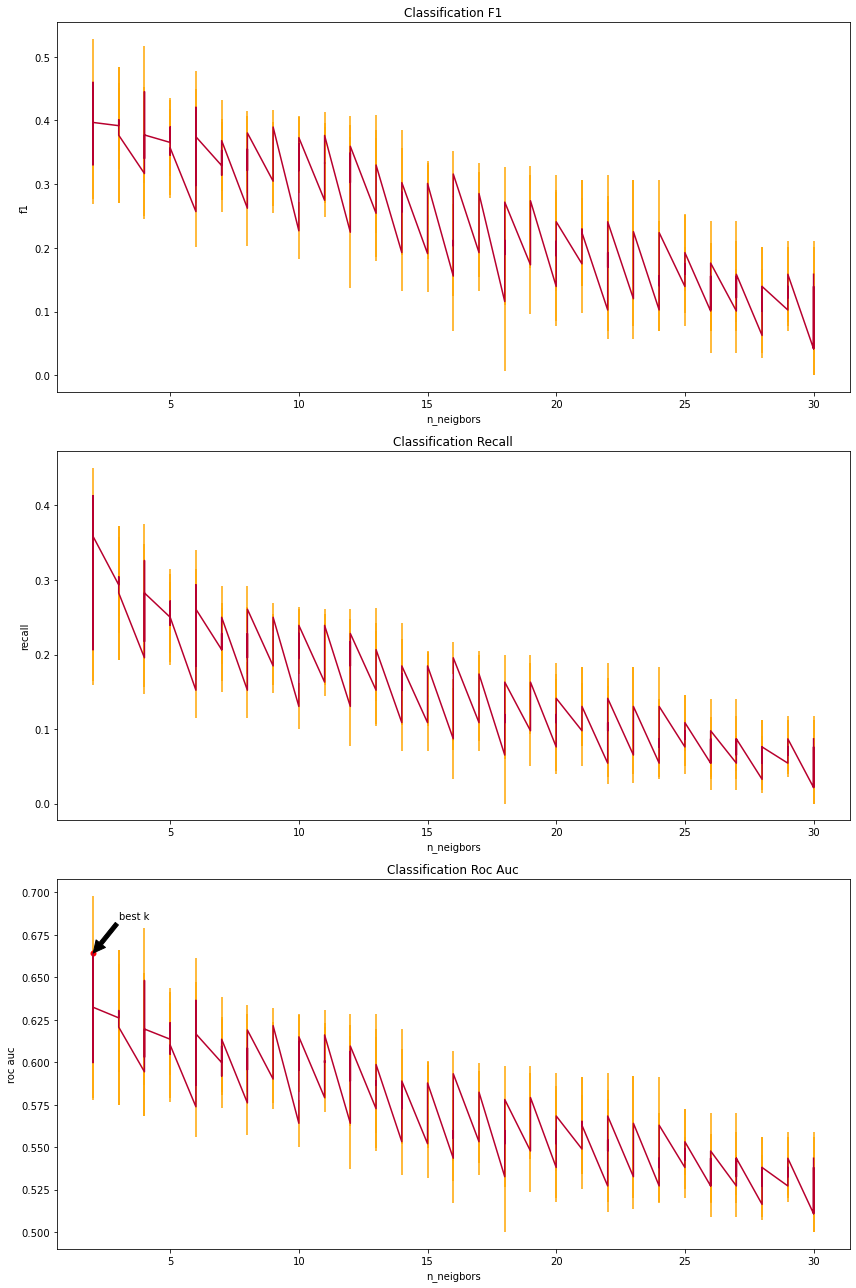



Permutation importances of the training set

OverTime                                           0.006815
NumCompaniesWorked                                 0.004160
StockOptionLevel                                   0.002400
JobRole_Laboratory_Technician                      0.000721
JobRole_Research_Scientist                         0.000443
JobRole_Sales_Representative                       0.000040
RelationshipSatisfaction                           0.000010
Age                                                0.000009
JobSatisfaction                                    0.000009
EnvironmentSatisfaction                            0.000007
JobInvolvement                                     0.000002
DistanceFromHome                                   0.000002
TrainingTimesLastYear                              0.000002
WorkLifeBalance                                    0.000000
JobRole_Manufacturing_Director                     0.000000
JobLevel                                           0.

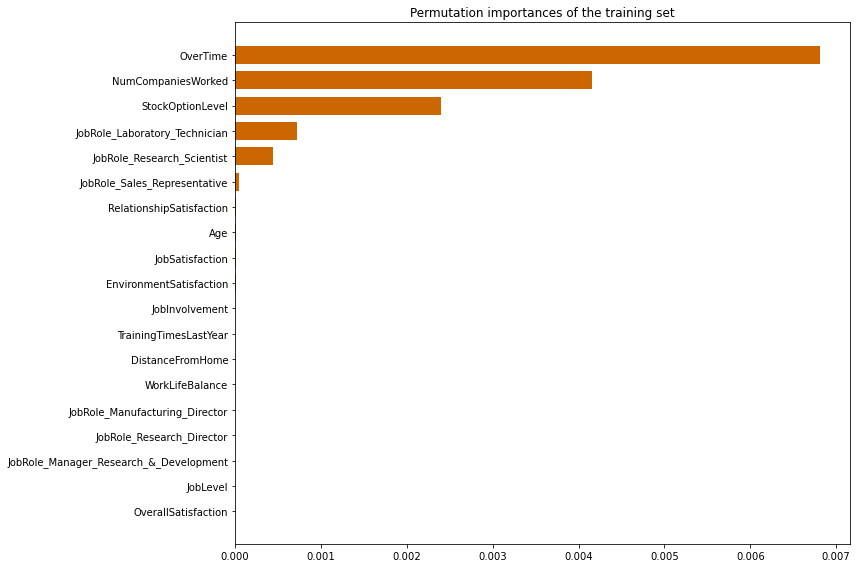



Predictions

Permutation importances of the test set

OverTime                                           0.072187
JobSatisfaction                                    0.038933
JobRole_Sales_Representative                       0.038357
Age                                                0.034043
WorkLifeBalance                                    0.031897
EnvironmentSatisfaction                            0.030666
JobInvolvement                                     0.016648
JobLevel                                           0.015593
RelationshipSatisfaction                           0.014634
StockOptionLevel                                   0.013929
OverallSatisfaction                                0.009850
TrainingTimesLastYear                              0.005920
JobRole_Research_Scientist                         0.001463
JobRole_Manager_Research_&_Development             0.001298
JobRole_Research_Director                          0.001181
JobRole_Manufacturing_Director              

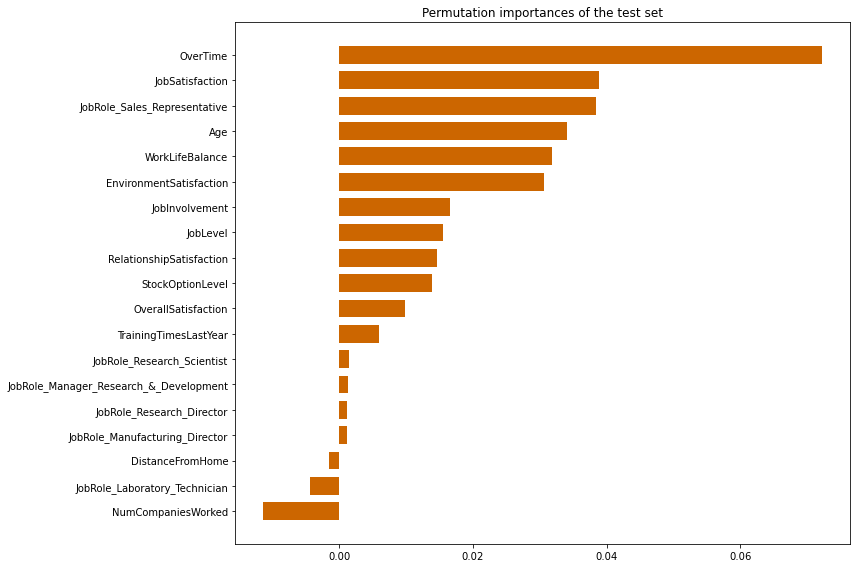



Confusion matrix


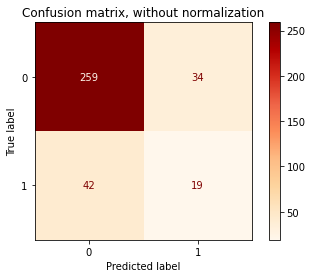

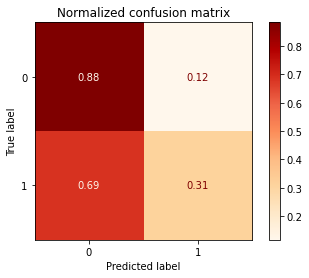


Classification report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       293
           1       0.36      0.31      0.33        61

    accuracy                           0.79       354
   macro avg       0.61      0.60      0.60       354
weighted avg       0.77      0.79      0.78       354


Metrics

Accuracy 0.7853107344632768
F1-score [0.87205387 0.33333333]
Precision [0.86046512 0.35849057]
Recall [0.88395904 0.31147541]
Roc_auc 0.5977172271023332


Roc curve



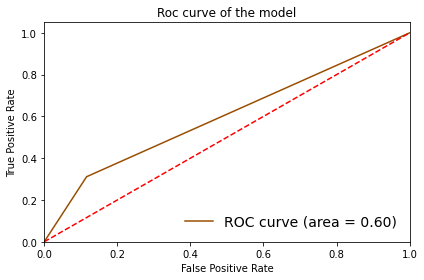


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6163392705669404
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


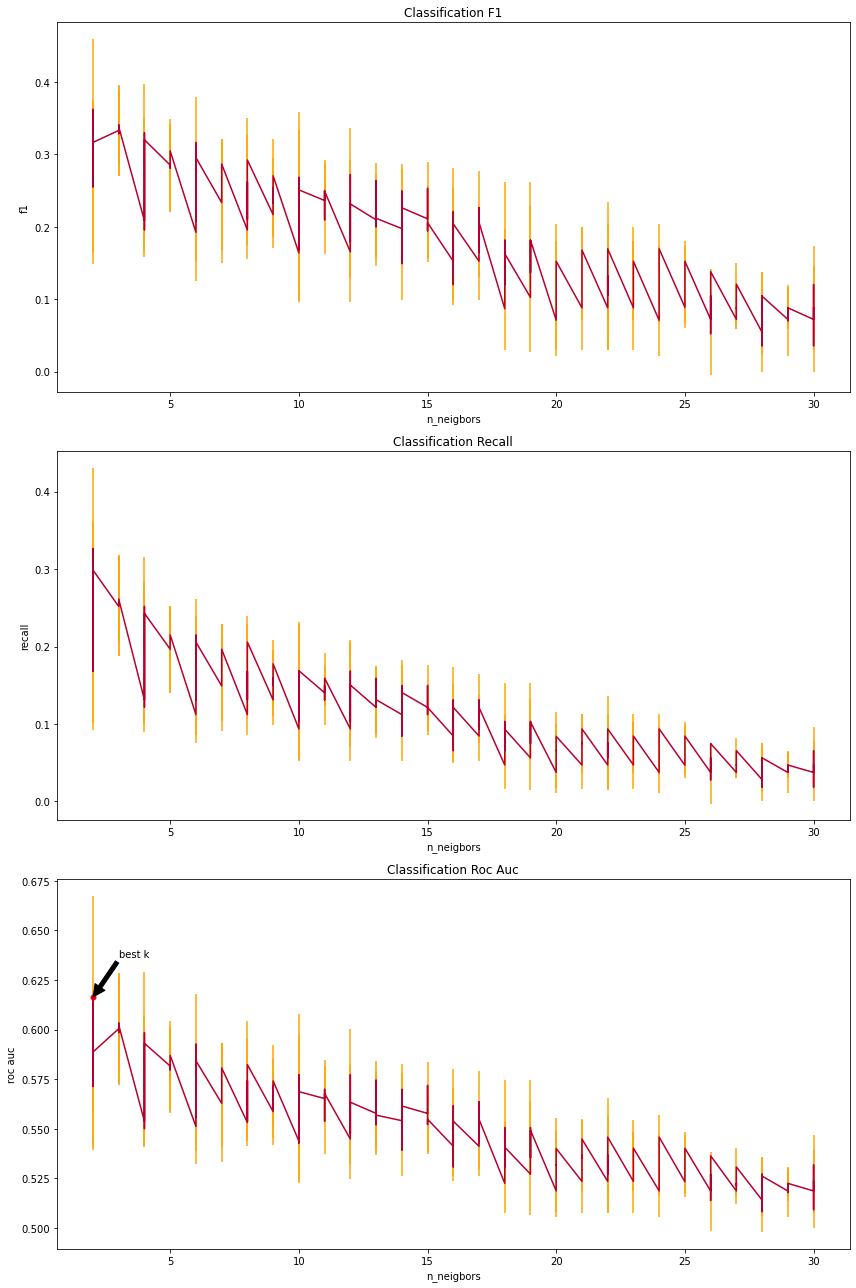



Permutation importances of the training set

OverTime                                           0.006303
NumCompaniesWorked                                 0.005065
StockOptionLevel                                   0.002640
Age                                                0.002079
DistanceFromHome                                   0.001510
JobRole_Laboratory_Technician                      0.001165
JobRole_Research_Scientist                         0.000276
JobRole_Sales_Representative                       0.000095
RelationshipSatisfaction                           0.000016
JobSatisfaction                                    0.000013
EnvironmentSatisfaction                            0.000012
TrainingTimesLastYear                              0.000002
WorkLifeBalance                                    0.000001
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

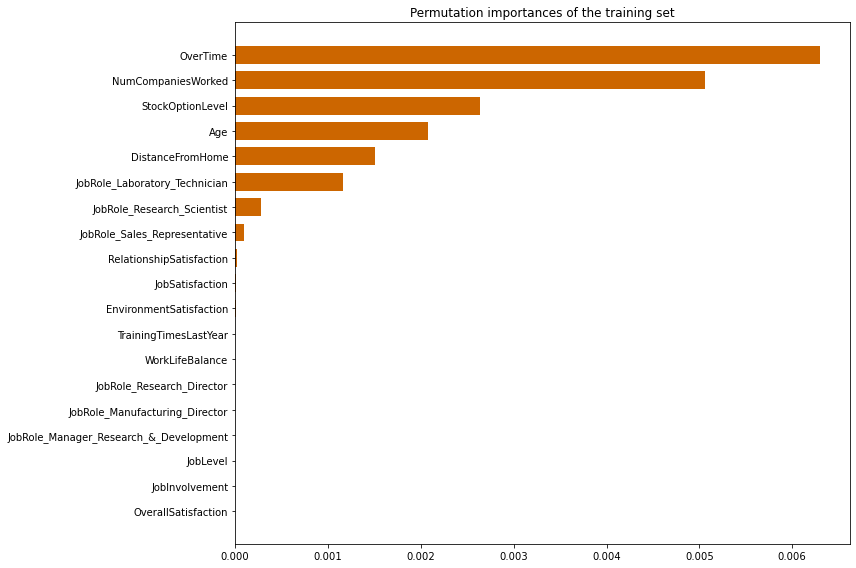



Predictions

Permutation importances of the test set

OverTime                                           0.107405
Age                                                0.077075
JobInvolvement                                     0.057946
JobSatisfaction                                    0.057688
StockOptionLevel                                   0.057361
WorkLifeBalance                                    0.049737
JobRole_Sales_Representative                       0.035562
NumCompaniesWorked                                 0.034812
DistanceFromHome                                   0.032375
OverallSatisfaction                                0.028579
EnvironmentSatisfaction                            0.028172
JobLevel                                           0.022310
RelationshipSatisfaction                           0.017679
JobRole_Laboratory_Technician                      0.011847
TrainingTimesLastYear                              0.010413
JobRole_Manufacturing_Director              

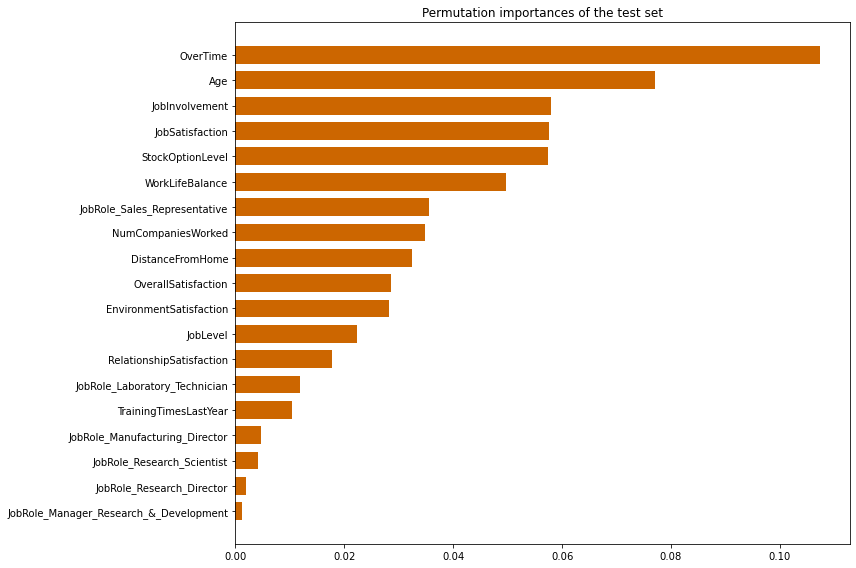



Confusion matrix


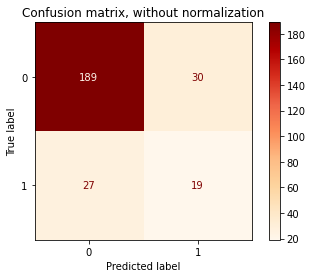

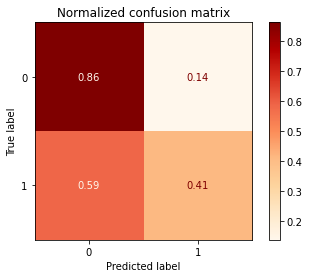


Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       219
           1       0.39      0.41      0.40        46

    accuracy                           0.78       265
   macro avg       0.63      0.64      0.63       265
weighted avg       0.79      0.78      0.79       265


Metrics

Accuracy 0.7849056603773585
F1-score [0.86896552 0.4       ]
Precision [0.875     0.3877551]
Recall [0.8630137  0.41304348]
Roc_auc 0.6380285884455033


Roc curve



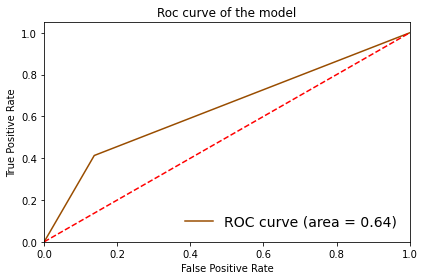


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6796232876712329
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


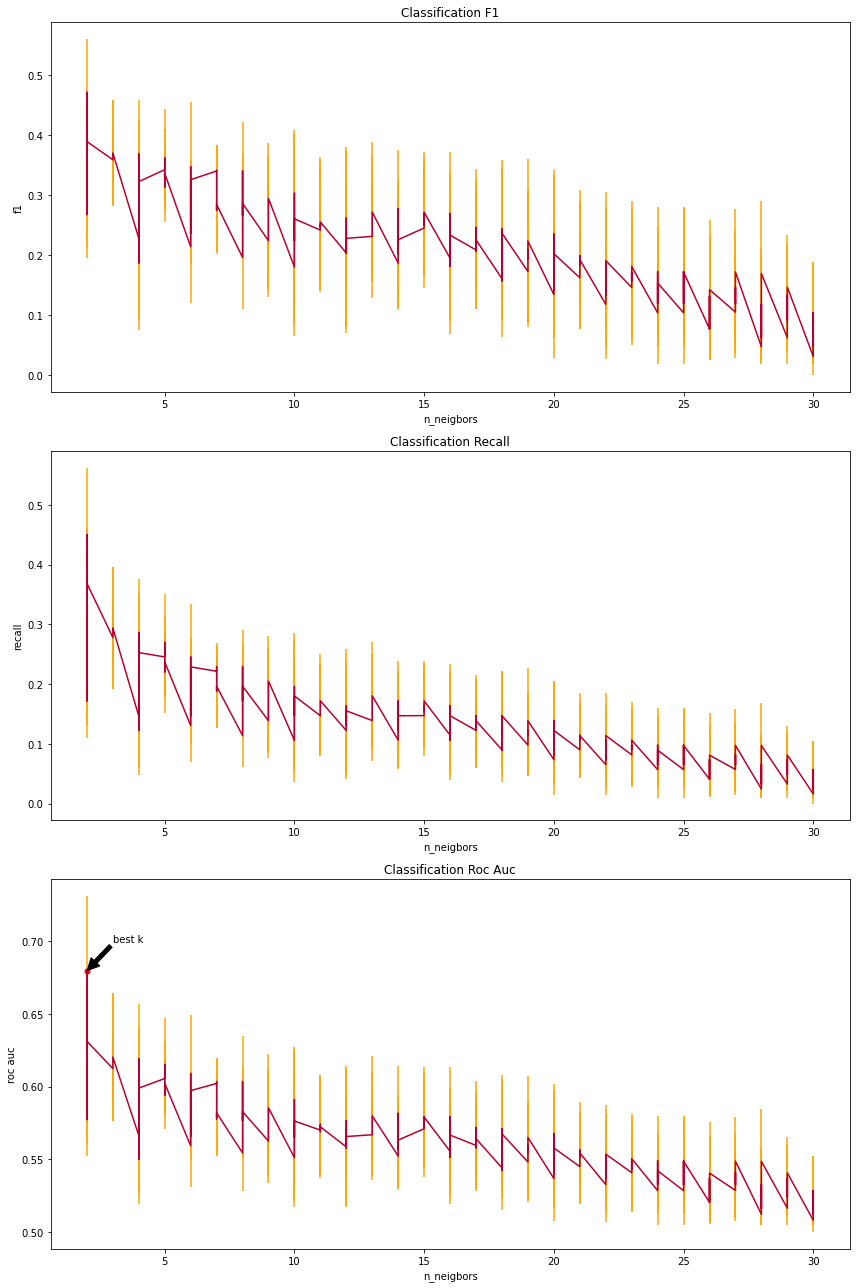



Permutation importances of the training set

OverTime                                           0.007917
NumCompaniesWorked                                 0.006226
JobRole_Sales_Representative                       0.003830
StockOptionLevel                                   0.003200
Age                                                0.002696
DistanceFromHome                                   0.001356
JobRole_Laboratory_Technician                      0.001091
JobRole_Manufacturing_Director                     0.000837
JobRole_Research_Scientist                         0.000302
EnvironmentSatisfaction                            0.000091
JobSatisfaction                                    0.000022
RelationshipSatisfaction                           0.000015
TrainingTimesLastYear                              0.000011
JobInvolvement                                     0.000001
WorkLifeBalance                                    0.000001
JobLevel                                           0.

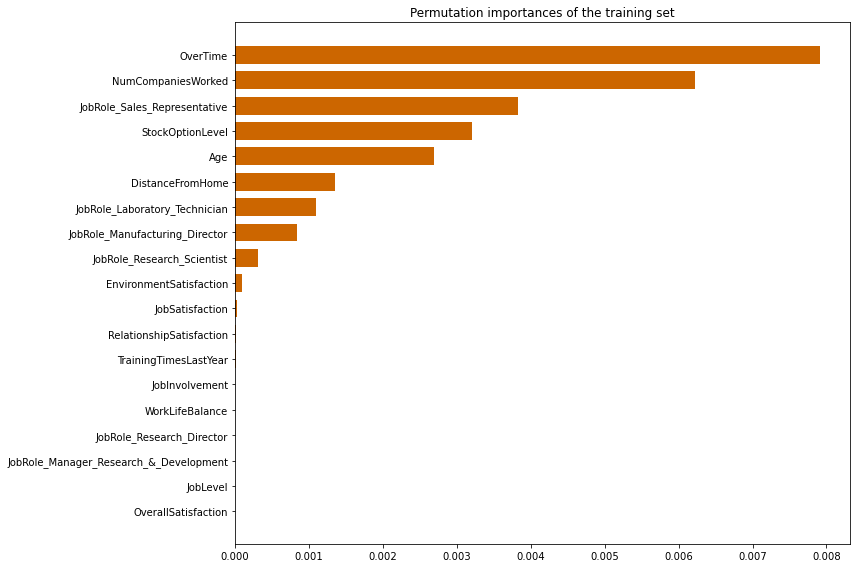



Predictions

Permutation importances of the test set

OverTime                                           0.113643
StockOptionLevel                                   0.091483
JobSatisfaction                                    0.079441
JobRole_Laboratory_Technician                      0.055490
Age                                                0.040499
WorkLifeBalance                                    0.035440
OverallSatisfaction                                0.026591
JobRole_Research_Scientist                         0.020669
JobInvolvement                                     0.019985
EnvironmentSatisfaction                            0.019012
JobRole_Sales_Representative                       0.018637
RelationshipSatisfaction                           0.017411
JobLevel                                           0.017145
NumCompaniesWorked                                 0.015820
DistanceFromHome                                   0.013356
JobRole_Manufacturing_Director              

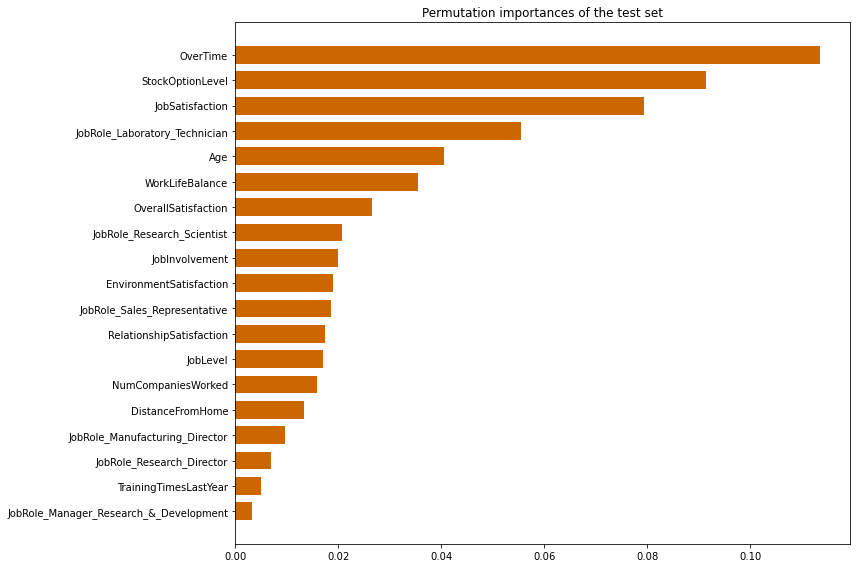



Confusion matrix


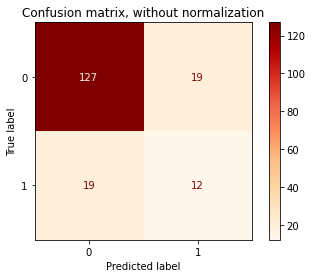

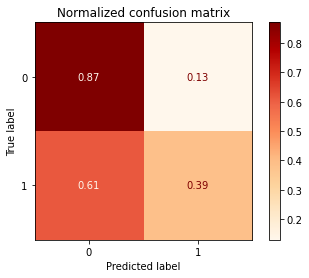


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       146
           1       0.39      0.39      0.39        31

    accuracy                           0.79       177
   macro avg       0.63      0.63      0.63       177
weighted avg       0.79      0.79      0.79       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.86986301 0.38709677]
Precision [0.86986301 0.38709677]
Recall [0.86986301 0.38709677]
Roc_auc 0.6284798939460893


Roc curve



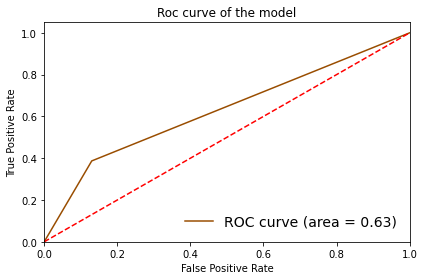


-------------------------------------------------------------------------------------------------------------



In [71]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6018276099648258
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


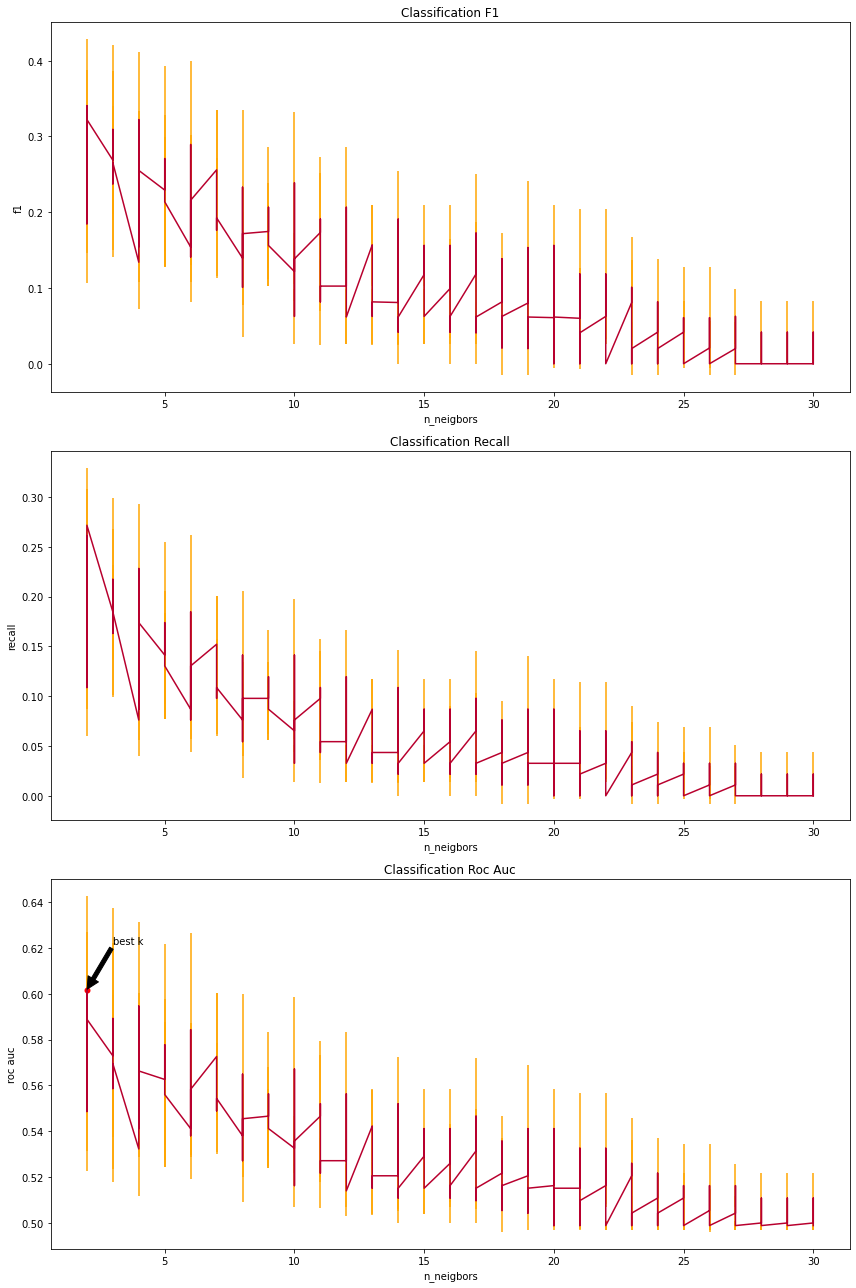



Permutation importances of the training set

NumCompaniesWorked                                 0.007248
StockOptionLevel                                   0.004195
TrainingTimesLastYear                              0.002618
JobInvolvement                                     0.000709
JobLevel                                           0.000005
WorkLifeBalance                                    0.000002
JobSatisfaction                                    0.000001
RelationshipSatisfaction                           0.000001
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Scientist                         0.000000
JobRole_Sales_Representative                       0.000000
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.

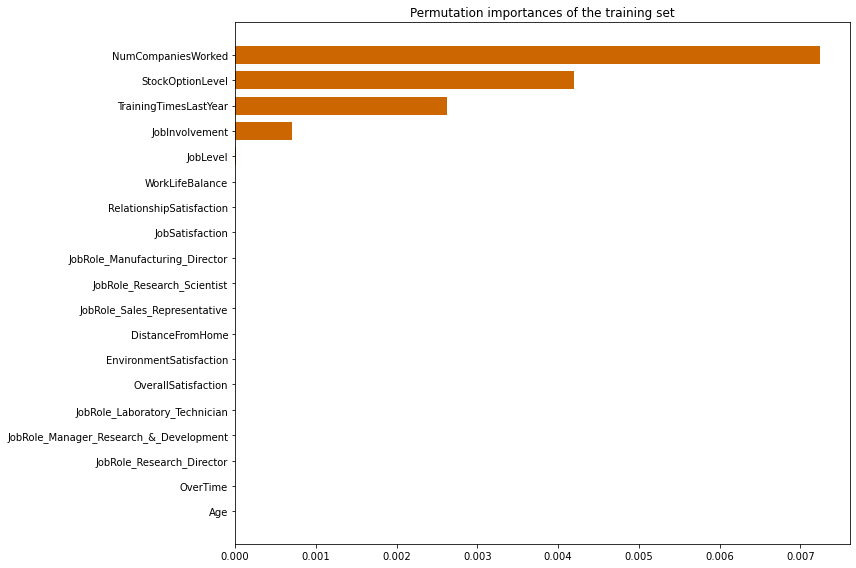



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.032879
JobSatisfaction                                    0.028157
RelationshipSatisfaction                           0.020271
OverTime                                           0.017619
EnvironmentSatisfaction                            0.017087
JobRole_Research_Scientist                         0.010197
JobLevel                                           0.004644
WorkLifeBalance                                    0.004045
JobRole_Sales_Representative                       0.003950
JobRole_Research_Director                          0.003102
JobRole_Manager_Research_&_Development             -0.000020
JobRole_Manufacturing_Director                     -0.000403
Age                                                -0.003116
JobInvolvement                                     -0.005027
OverallSatisfaction                                -0.008191
NumCompaniesWorked                     

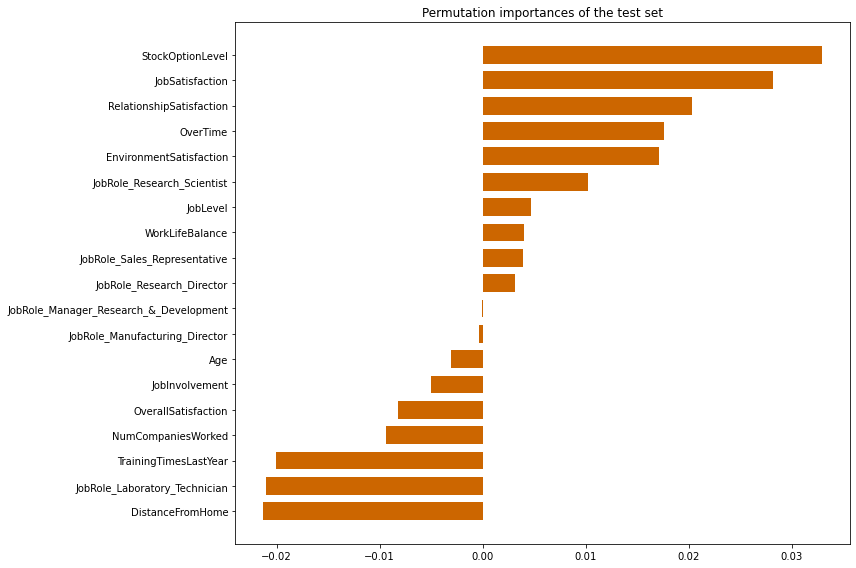



Confusion matrix


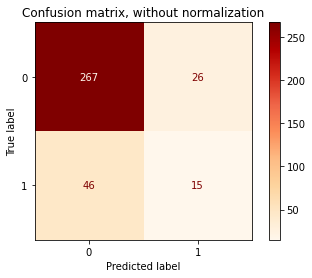

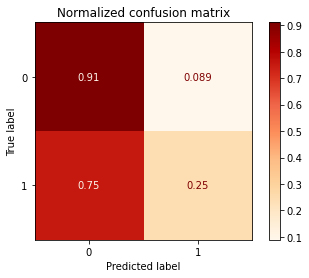


Classification report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       293
           1       0.37      0.25      0.29        61

    accuracy                           0.80       354
   macro avg       0.61      0.58      0.59       354
weighted avg       0.77      0.80      0.78       354


Metrics

Accuracy 0.7966101694915254
F1-score [0.88118812 0.29411765]
Precision [0.85303514 0.36585366]
Recall [0.9112628  0.24590164]
Roc_auc 0.5785822189895373


Roc curve



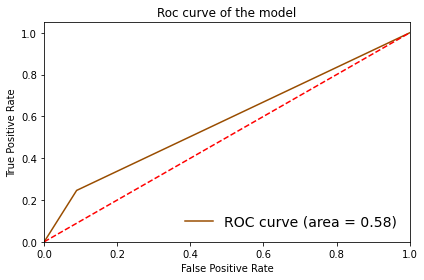


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5845080913363394
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


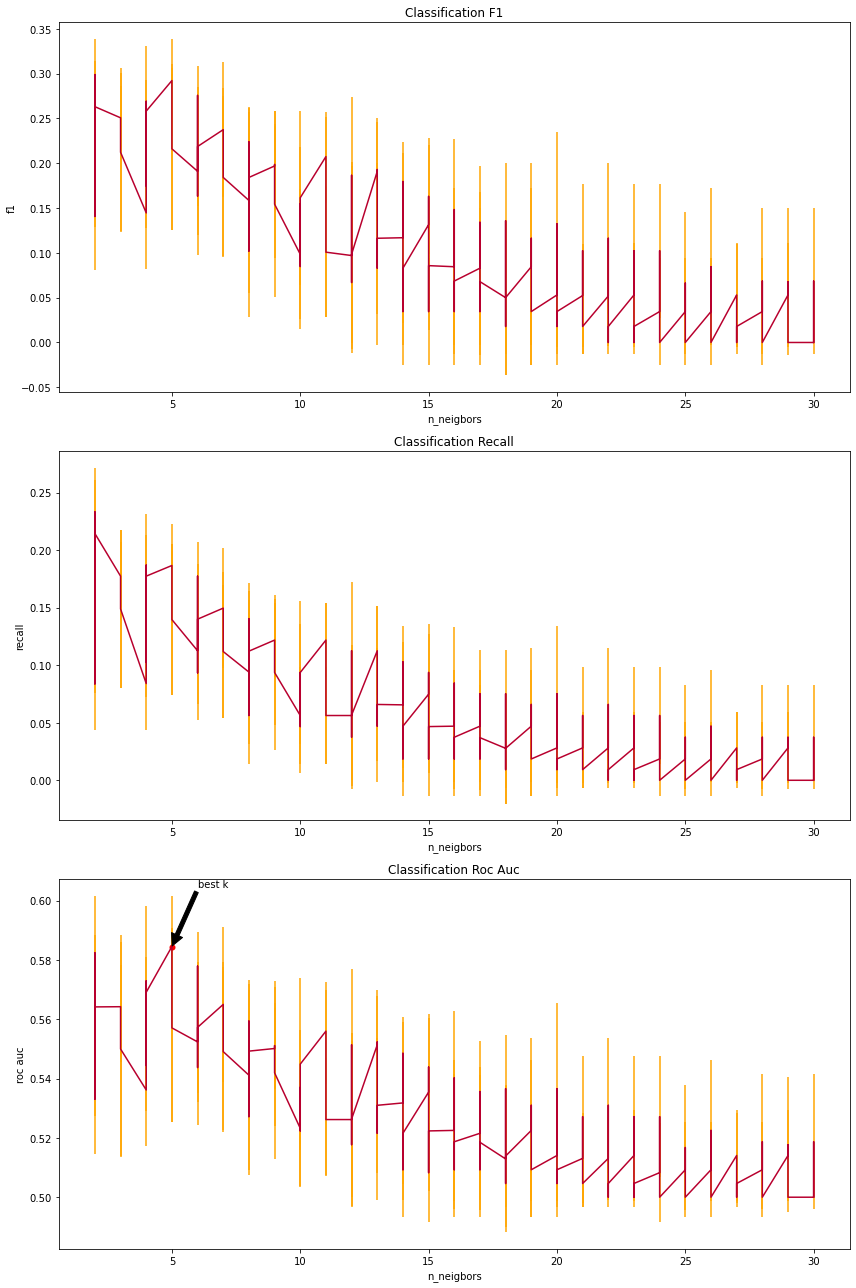



Permutation importances of the training set

StockOptionLevel                                   0.016403
JobLevel                                           0.016334
NumCompaniesWorked                                 0.014416
OverTime                                           0.013038
JobRole_Laboratory_Technician                      0.012128
WorkLifeBalance                                    0.009378
EnvironmentSatisfaction                            0.008082
OverallSatisfaction                                0.005391
JobRole_Manufacturing_Director                     0.003061
JobRole_Sales_Representative                       0.001319
JobRole_Research_Director                          0.001147
JobRole_Manager_Research_&_Development             0.000310
RelationshipSatisfaction                           0.000192
JobSatisfaction                                    0.000104
DistanceFromHome                                   -0.000227
TrainingTimesLastYear                              -

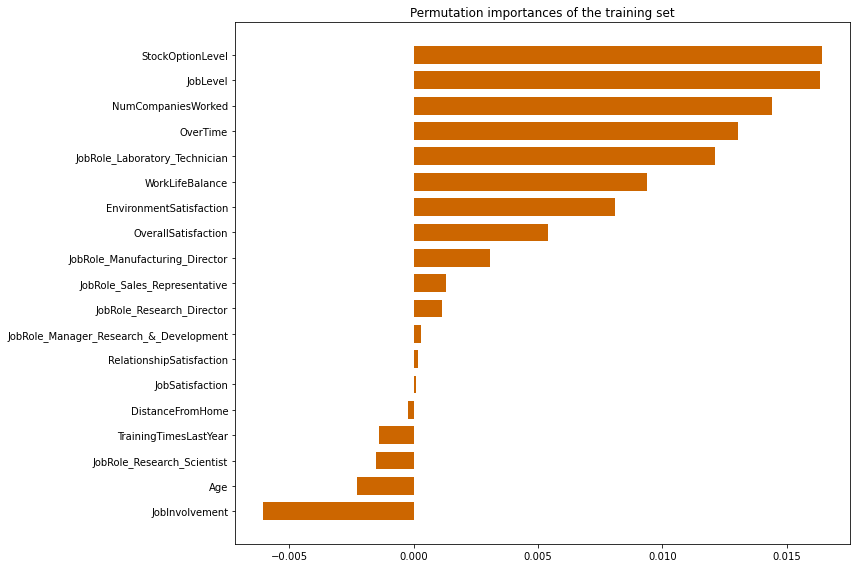



Predictions

Permutation importances of the test set

OverTime                                           0.037691
StockOptionLevel                                   0.023317
JobLevel                                           0.018821
OverallSatisfaction                                0.010522
JobRole_Research_Director                          0.006115
JobRole_Sales_Representative                       0.005891
JobInvolvement                                     0.002963
JobRole_Manufacturing_Director                     0.001147
JobRole_Manager_Research_&_Development             0.000094
WorkLifeBalance                                    -0.000491
RelationshipSatisfaction                           -0.008274
JobSatisfaction                                    -0.012105
EnvironmentSatisfaction                            -0.013436
JobRole_Research_Scientist                         -0.015198
DistanceFromHome                                   -0.019089
NumCompaniesWorked                    

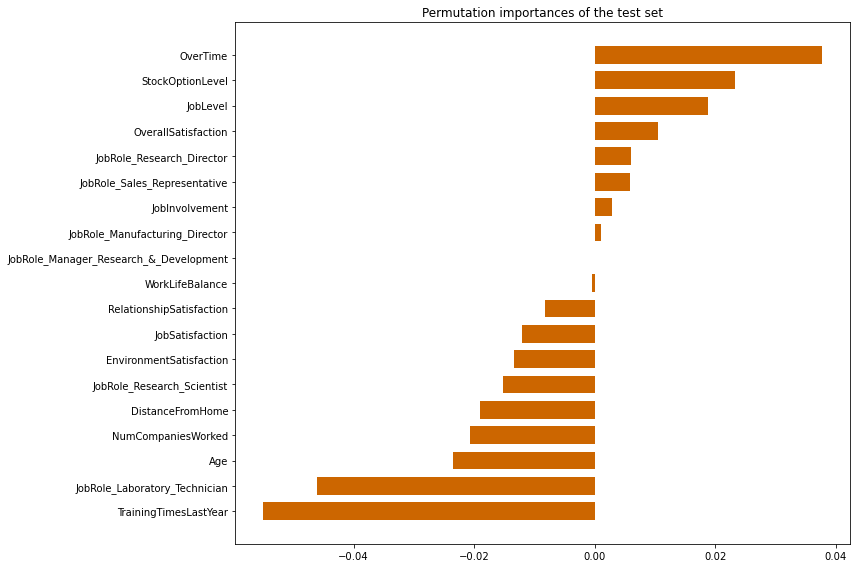



Confusion matrix


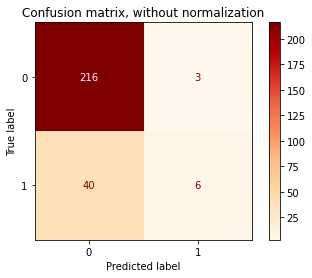

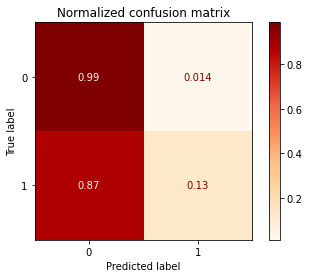


Classification report
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       219
           1       0.67      0.13      0.22        46

    accuracy                           0.84       265
   macro avg       0.76      0.56      0.56       265
weighted avg       0.81      0.84      0.79       265


Metrics

Accuracy 0.8377358490566038
F1-score [0.90947368 0.21818182]
Precision [0.84375    0.66666667]
Recall [0.98630137 0.13043478]
Roc_auc 0.5583680762358546


Roc curve



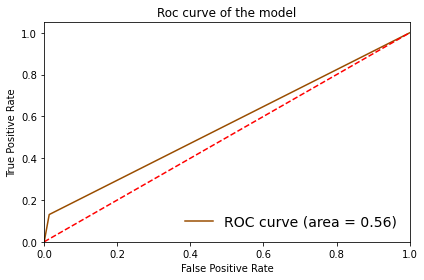


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6361743261157755
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


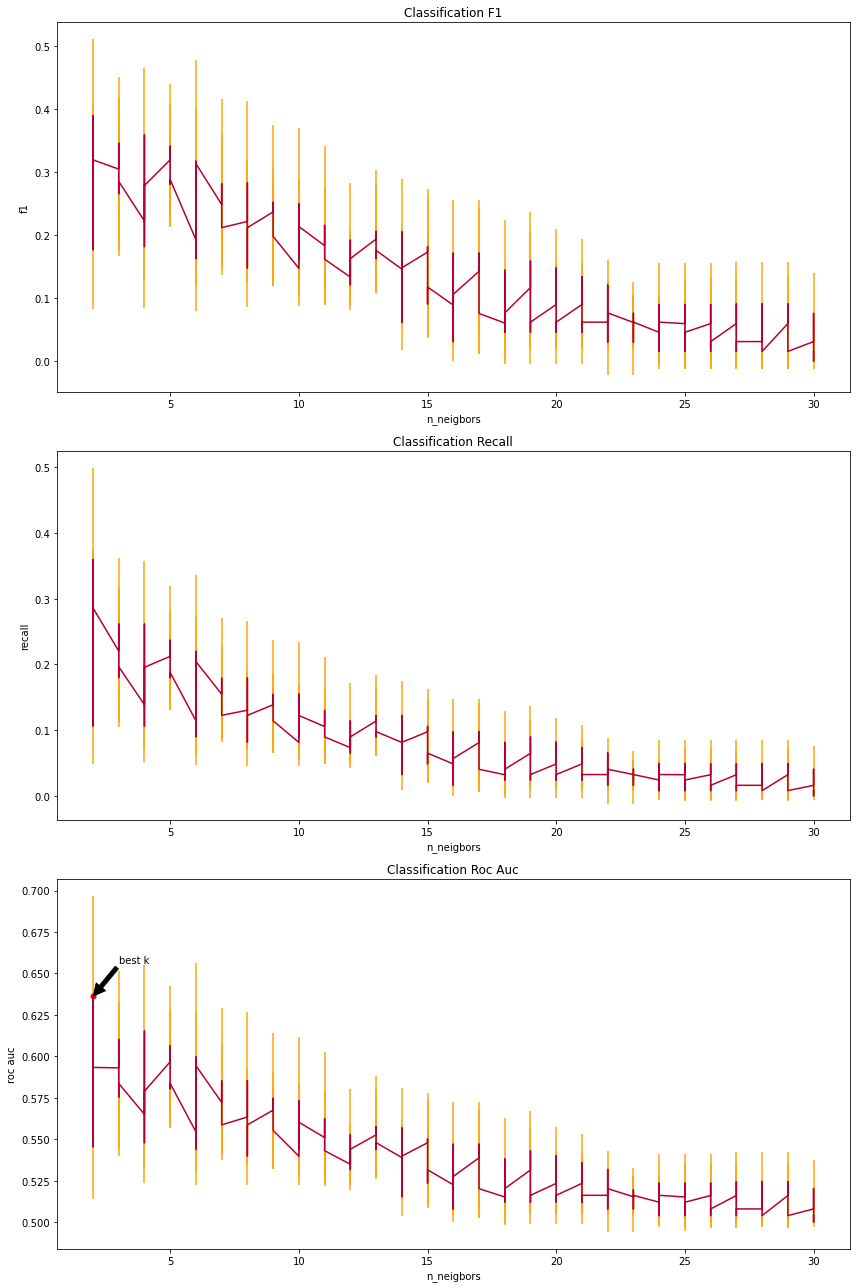



Permutation importances of the training set

NumCompaniesWorked                                 0.007068
StockOptionLevel                                   0.002521
TrainingTimesLastYear                              0.001372
JobInvolvement                                     0.000126
WorkLifeBalance                                    0.000105
EnvironmentSatisfaction                            0.000002
OverallSatisfaction                                0.000002
JobLevel                                           0.000001
JobSatisfaction                                    0.000001
Age                                                0.000000
DistanceFromHome                                   0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.

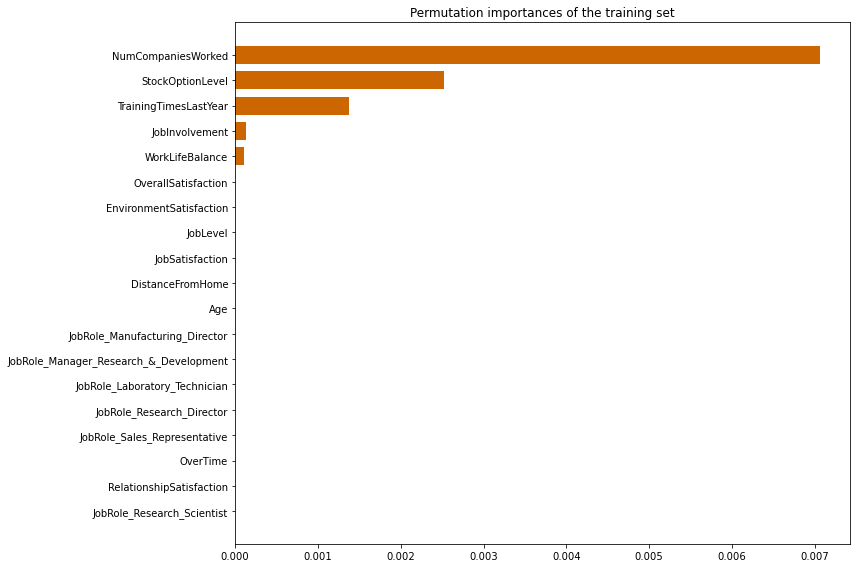



Predictions

Permutation importances of the test set

OverTime                                           0.083352
NumCompaniesWorked                                 0.066438
JobLevel                                           0.058396
StockOptionLevel                                   0.052276
JobInvolvement                                     0.034147
RelationshipSatisfaction                           0.030203
JobRole_Laboratory_Technician                      0.030060
TrainingTimesLastYear                              0.029286
EnvironmentSatisfaction                            0.021829
Age                                                0.019498
JobSatisfaction                                    0.010683
WorkLifeBalance                                    0.009456
JobRole_Manufacturing_Director                     0.006209
DistanceFromHome                                   0.002916
JobRole_Research_Director                          0.000022
JobRole_Sales_Representative                

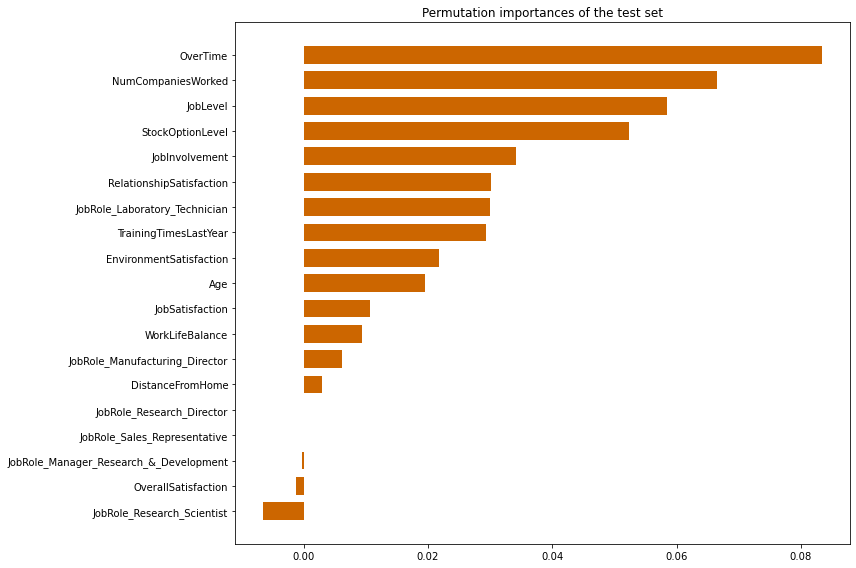



Confusion matrix


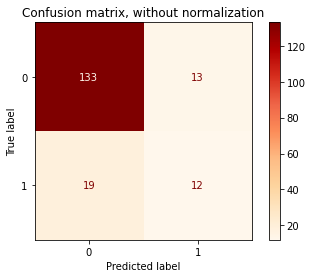

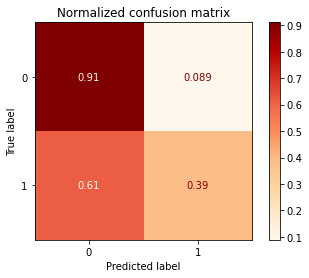


Classification report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       146
           1       0.48      0.39      0.43        31

    accuracy                           0.82       177
   macro avg       0.68      0.65      0.66       177
weighted avg       0.81      0.82      0.81       177


Metrics

Accuracy 0.8192090395480226
F1-score [0.89261745 0.42857143]
Precision [0.875 0.48 ]
Recall [0.9109589  0.38709677]
Roc_auc 0.6490278391515687


Roc curve



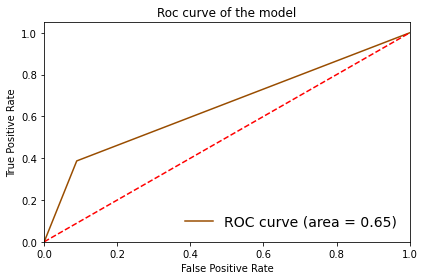


-------------------------------------------------------------------------------------------------------------



In [72]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6518792834608551
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


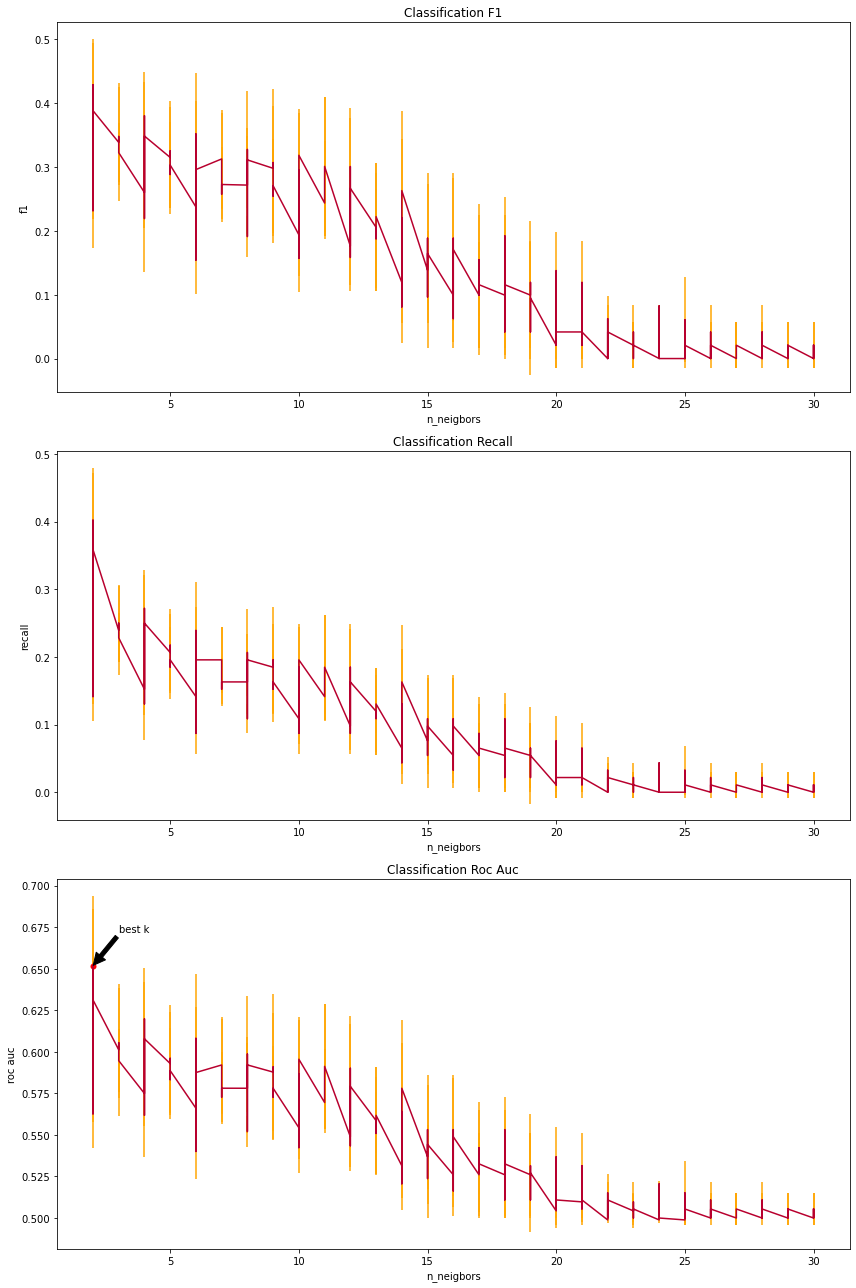



Permutation importances of the training set

StockOptionLevel                                   0.002925
JobInvolvement                                     0.000080
JobRole_Sales_Representative                       0.000060
OverTime                                           0.000032
TrainingTimesLastYear                              0.000015
JobSatisfaction                                    0.000012
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.000000
NumCompaniesWorked                                 0.

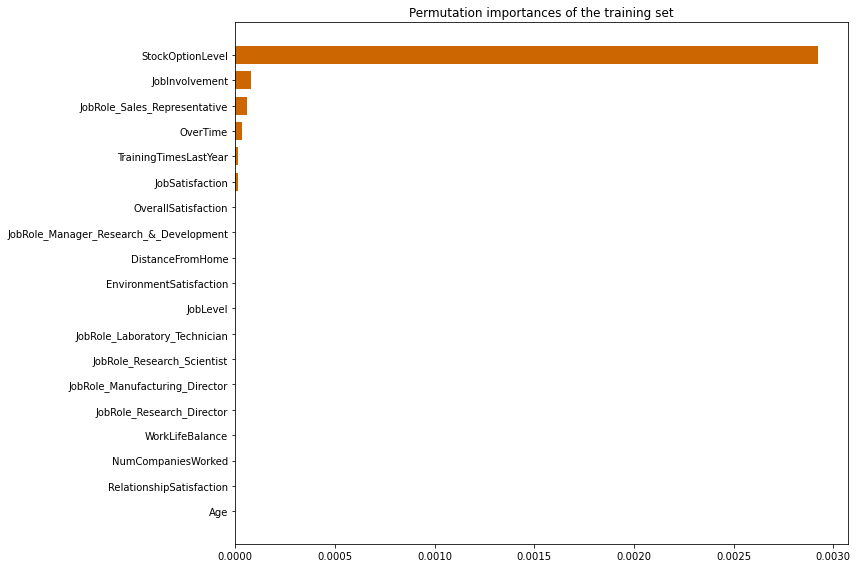



Predictions

Permutation importances of the test set

OverTime                                           0.069129
EnvironmentSatisfaction                            0.054042
WorkLifeBalance                                    0.038385
JobRole_Sales_Representative                       0.033525
Age                                                0.032261
OverallSatisfaction                                0.030535
StockOptionLevel                                   0.027830
JobRole_Research_Scientist                         0.023563
JobLevel                                           0.020464
JobRole_Laboratory_Technician                      0.020050
JobSatisfaction                                    0.019851
JobInvolvement                                     0.018562
RelationshipSatisfaction                           0.016740
NumCompaniesWorked                                 0.008267
JobRole_Research_Director                          0.005517
TrainingTimesLastYear                       

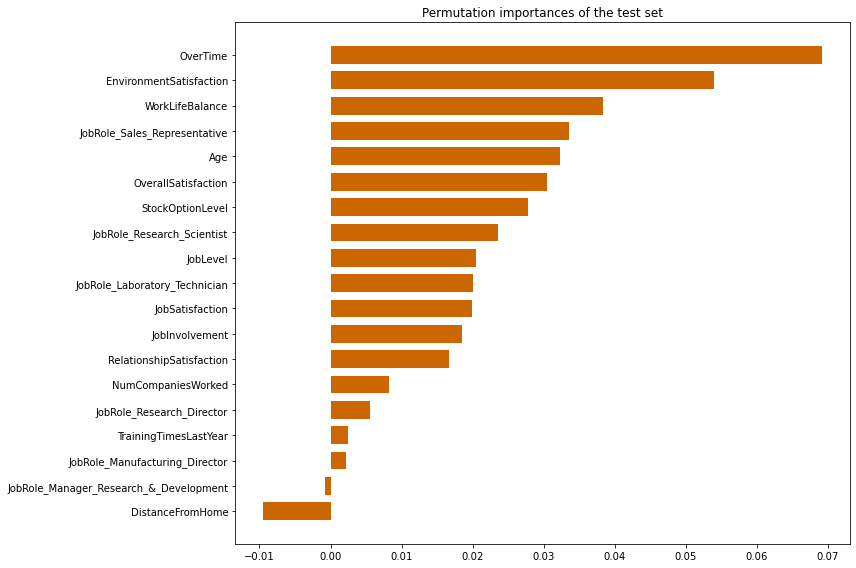



Confusion matrix


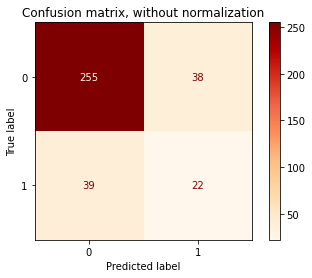

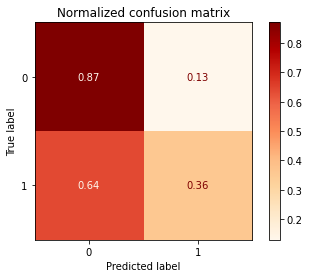


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       293
           1       0.37      0.36      0.36        61

    accuracy                           0.78       354
   macro avg       0.62      0.62      0.62       354
weighted avg       0.78      0.78      0.78       354


Metrics

Accuracy 0.7824858757062146
F1-score [0.86882453 0.36363636]
Precision [0.86734694 0.36666667]
Recall [0.87030717 0.36065574]
Roc_auc 0.6154814524702065


Roc curve



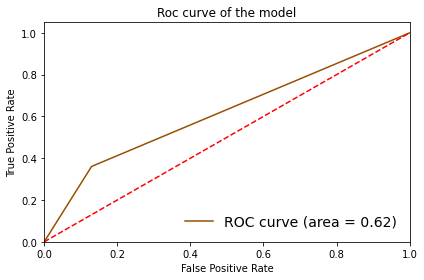


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6265076616023958
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


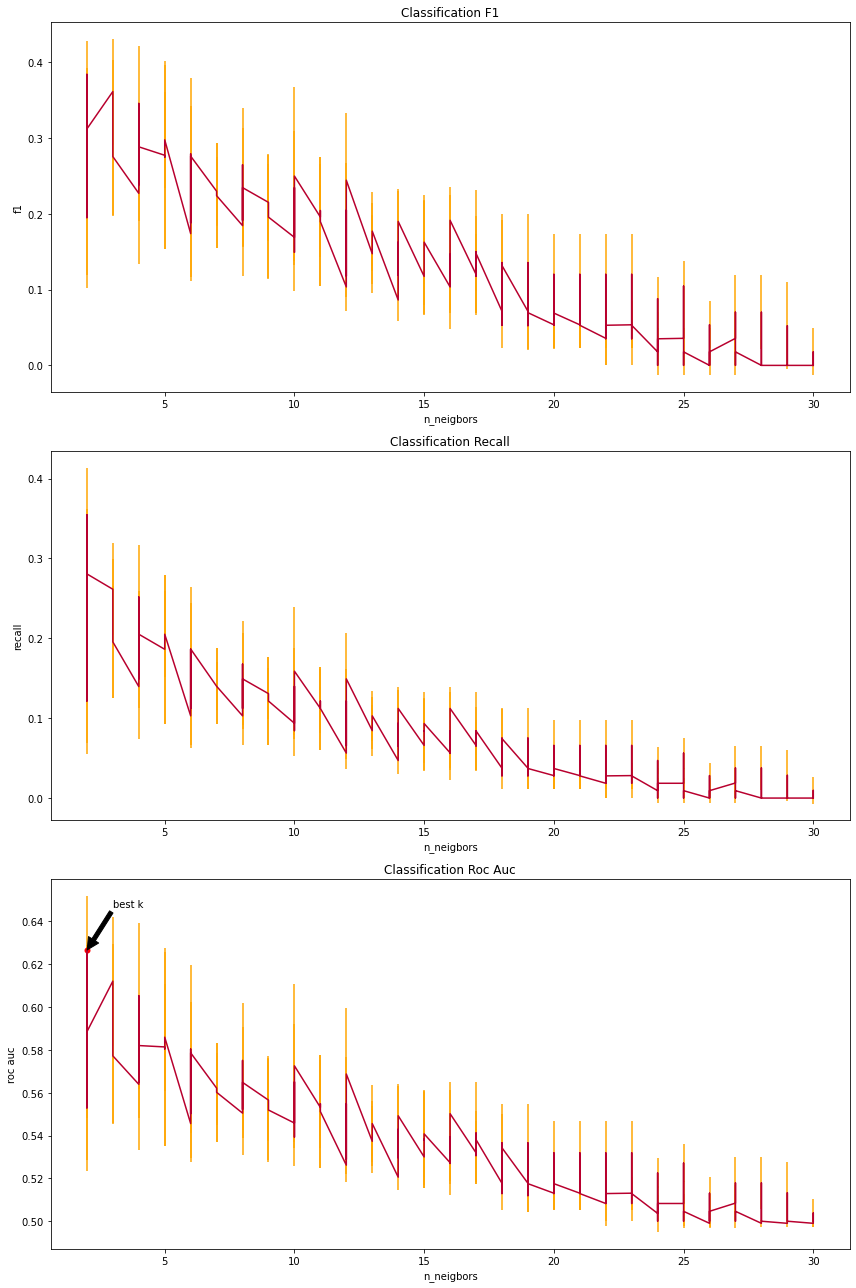



Permutation importances of the training set

DistanceFromHome                                   0.003989
StockOptionLevel                                   0.002060
WorkLifeBalance                                    0.000113
JobRole_Sales_Representative                       0.000042
OverTime                                           0.000035
TrainingTimesLastYear                              0.000024
JobInvolvement                                     0.000020
JobSatisfaction                                    0.000009
Age                                                0.000007
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.

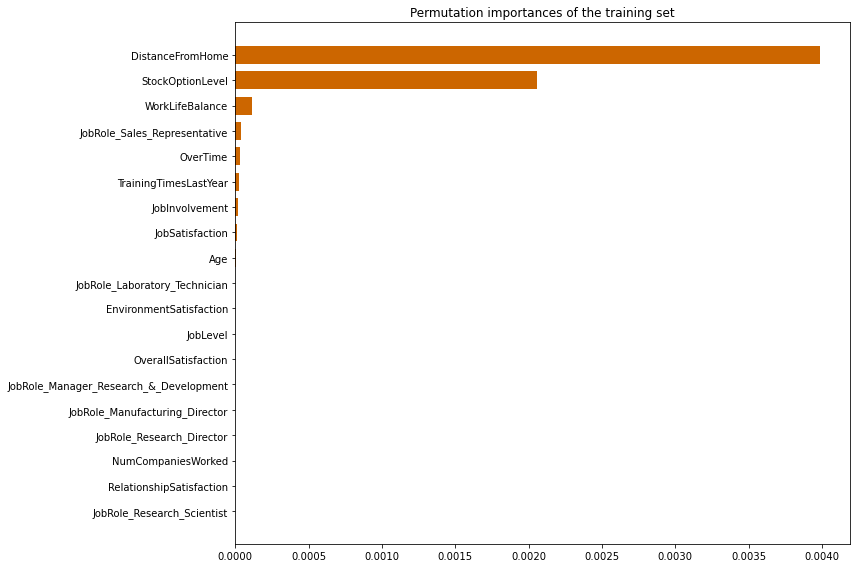



Predictions

Permutation importances of the test set

OverTime                                           0.078301
JobInvolvement                                     0.041910
WorkLifeBalance                                    0.040391
OverallSatisfaction                                0.039443
Age                                                0.029561
EnvironmentSatisfaction                            0.029204
JobSatisfaction                                    0.026062
StockOptionLevel                                   0.024390
JobRole_Laboratory_Technician                      0.022712
JobRole_Sales_Representative                       0.021670
RelationshipSatisfaction                           0.019868
NumCompaniesWorked                                 0.011813
DistanceFromHome                                   0.010378
JobRole_Research_Director                          0.009624
JobLevel                                           0.009108
JobRole_Manufacturing_Director              

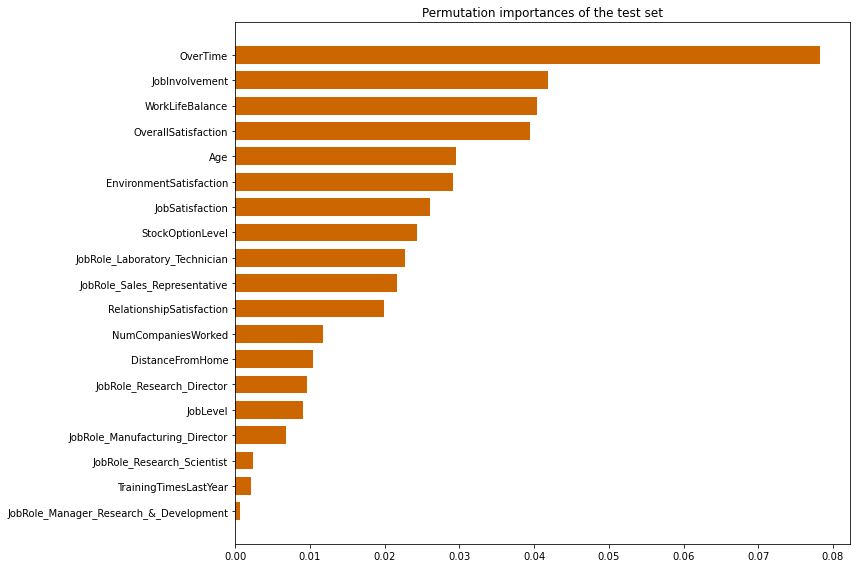



Confusion matrix


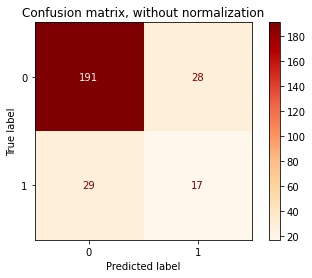

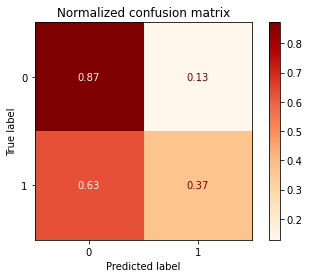


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       219
           1       0.38      0.37      0.37        46

    accuracy                           0.78       265
   macro avg       0.62      0.62      0.62       265
weighted avg       0.78      0.78      0.78       265


Metrics

Accuracy 0.7849056603773585
F1-score [0.87015945 0.37362637]
Precision [0.86818182 0.37777778]
Recall [0.87214612 0.36956522]
Roc_auc 0.6208556680563827


Roc curve



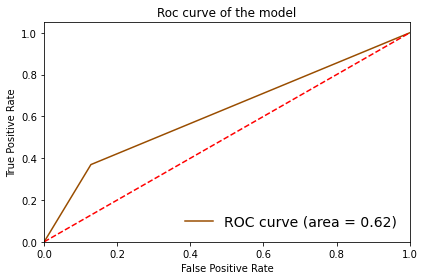


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6852739726027397
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


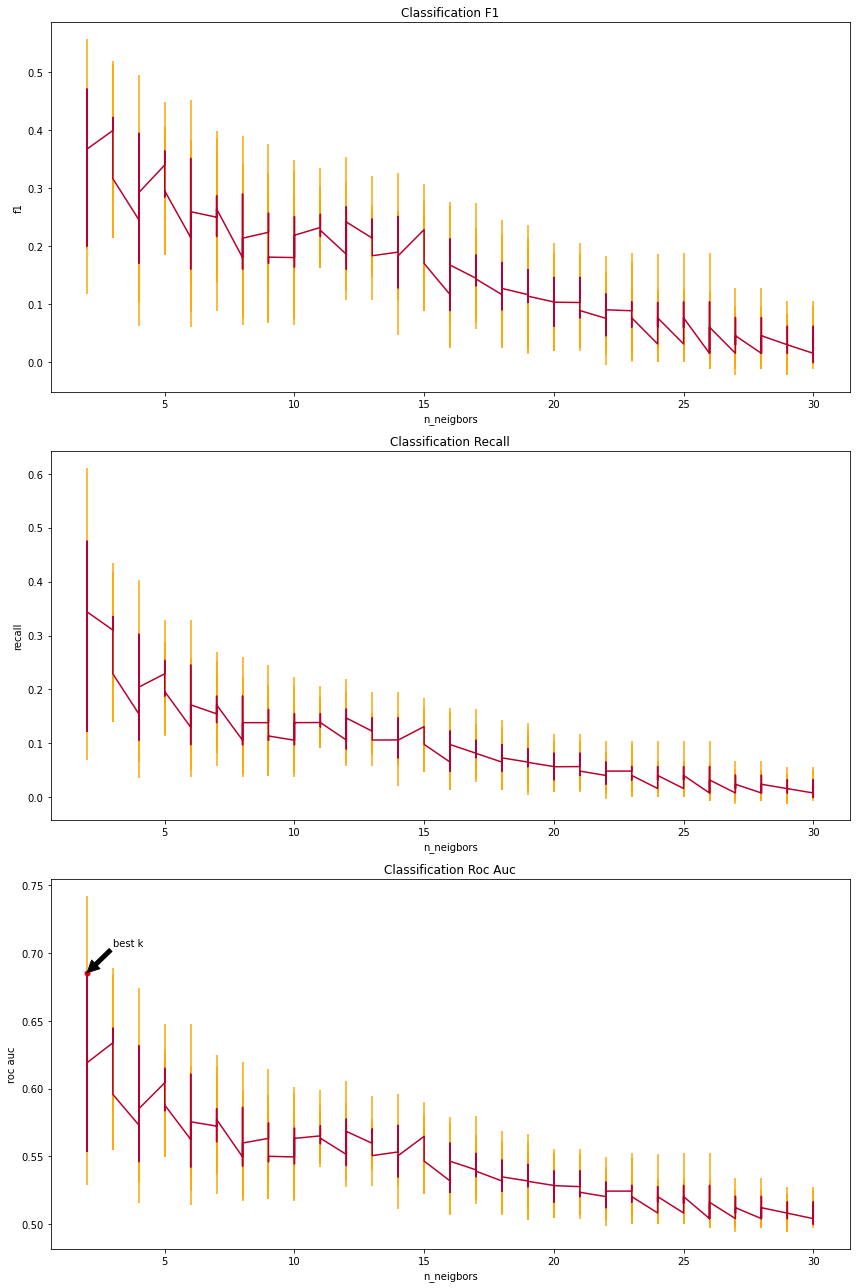



Permutation importances of the training set

JobRole_Sales_Representative                       0.007979
DistanceFromHome                                   0.001768
StockOptionLevel                                   0.000917
TrainingTimesLastYear                              0.000087
WorkLifeBalance                                    0.000052
OverTime                                           0.000046
JobInvolvement                                     0.000036
JobSatisfaction                                    0.000020
EnvironmentSatisfaction                            0.000011
Age                                                0.000008
OverallSatisfaction                                0.000006
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

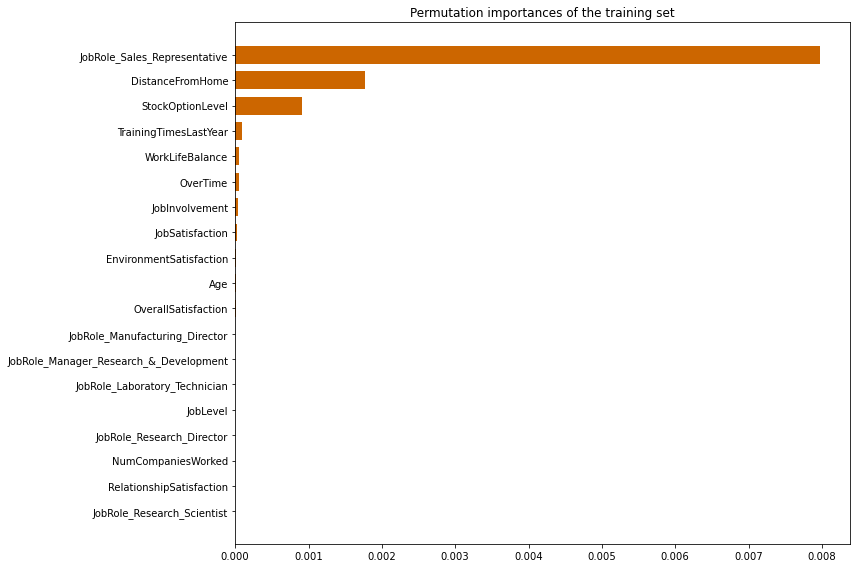



Predictions

Permutation importances of the test set

OverTime                                           0.074757
JobRole_Laboratory_Technician                      0.056529
StockOptionLevel                                   0.055612
OverallSatisfaction                                0.041074
JobSatisfaction                                    0.031098
JobRole_Research_Scientist                         0.027905
NumCompaniesWorked                                 0.025663
JobRole_Sales_Representative                       0.020901
Age                                                0.020736
JobInvolvement                                     0.018637
WorkLifeBalance                                    0.017764
TrainingTimesLastYear                              0.015057
JobLevel                                           0.013058
JobRole_Research_Director                          0.011953
JobRole_Manufacturing_Director                     0.011710
EnvironmentSatisfaction                     

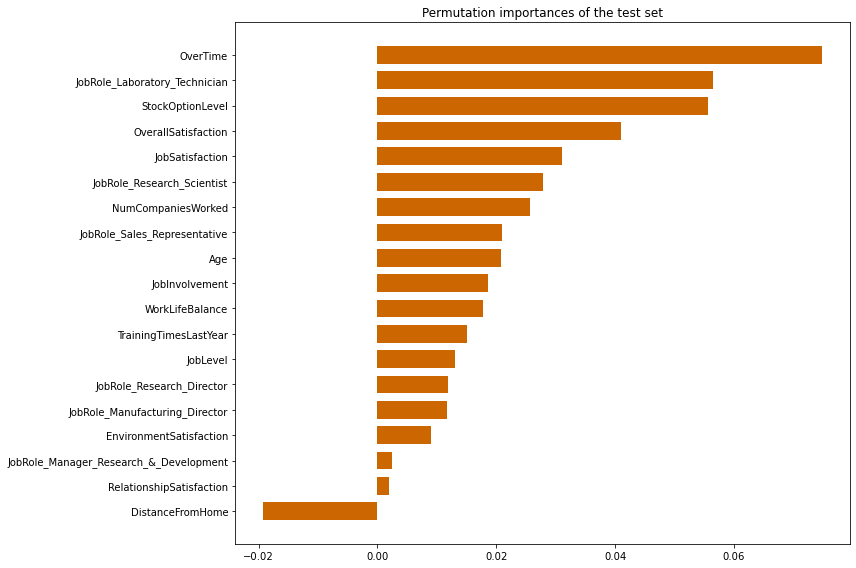



Confusion matrix


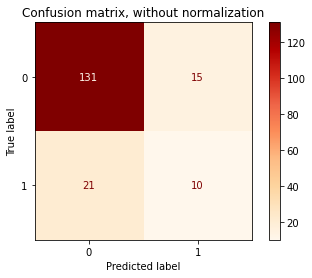

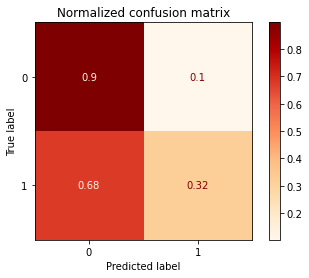


Classification report
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       146
           1       0.40      0.32      0.36        31

    accuracy                           0.80       177
   macro avg       0.63      0.61      0.62       177
weighted avg       0.78      0.80      0.79       177


Metrics

Accuracy 0.7966101694915254
F1-score [0.87919463 0.35714286]
Precision [0.86184211 0.4       ]
Recall [0.89726027 0.32258065]
Roc_auc 0.6099204595669465


Roc curve



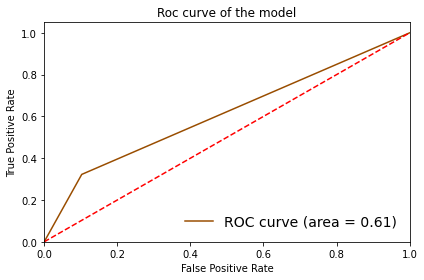


-------------------------------------------------------------------------------------------------------------



In [73]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [74]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.04436860068259386, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.5925697980193588},
  '70-30': {'fpr': [0.0, 0.1415525114155251, 1.0],
   'tpr': [0.0, 0.391304347826087, 1.0],
   'roc': 0.6248759182052808},
  '80-20': {'fpr': [0.0, 0.136986301369863, 1.0],
   'tpr': [0.0, 0.41935483870967744, 1.0],
   'roc': 0.6411842686699072}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.11604095563139932, 1.0],
   'tpr': [0.0, 0.3114754098360656, 1.0],
   'roc': 0.5977172271023332},
  '70-30': {'fpr': [0.0, 0.136986301369863, 1.0],
   'tpr': [0.0, 0.41304347826086957, 1.0],
   'roc': 0.6380285884455033},
  '80-20': {'fpr': [0.0, 0.13013698630136986, 1.0],
   'tpr': [0.0, 0.3870967741935484, 1.0],
   'roc': 0.6284798939460893}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.08873720136518772, 1.0],
   'tpr': [0.0, 0.2459016393442623, 1.0],
   'roc': 0.5785822189895373},
  '70-30': {'fpr': [0.0, 0.0136986301369863, 1.0],
   'tpr': [0.0, 0.130434782

In [83]:
temporal_info = {}

In [84]:
model_name = '20f onehot-encoded kmeans discretized'

In [85]:
temporal_info[model_name] = scaler_dict['RobustScaler']['80-20']
temporal_info

{'20f onehot-encoded kmeans discretized': {'fpr': [0.0,
   0.08904109589041095,
   1.0],
  'tpr': [0.0, 0.3870967741935484, 1.0],
  'roc': 0.6490278391515687}}

In [86]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['kmeans']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)